# Generating Account Features and Exploring Clustering Techniques

## Step 1. Generating Account Features

Run a bigquery to get btc transaction data between '2020-01-15' and '2020-1-22'

where  the transaction is succesfull, amount xrp is not null, fee amount is not null, destination is not null, and account hash is not null.

Goal: Get BigQuery Data into workable form as show below:


|Account Hash|Sum of BTC Received| Sum of BTC Sent|Sum of Fees| Number of Txns Sent|Number of Txns Received|Max BTC Sent| Max BTC Received| Stdev BTC Sent| Stdev BTC Received|Max_AutoCorrelation|
|-----|-------|------|------|-----|-----|-------|-----|------------|-----------|--------|




Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import preprocessing
#from scipy.stats import shapiro
from scipy.cluster.hierarchy import dendrogram, linkage 
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from google.cloud import bigquery
from google.oauth2 import service_account
import os.path
from os import path
import json
from datetime import datetime, timedelta

Setting Window for Query

In [2]:
start_date='2020-01-15'
end_date='2020-01-22'

In [3]:
cred_path='../../../credential/Xpring Dev Sandbox-edb2a98acf17.json'

In [4]:
path.exists(cred_path)

True

In [5]:
def get_gcp_creds(key_path):
    """
    Return GCP credentials from local .json
    
    Parameters
    ----------
    key_path: str
        Path to local credential .json
    """
    try:
        credentials = service_account.Credentials.from_service_account_file(
            key_path,
            scopes = ["https://www.googleapis.com/auth/cloud-platform"]
        )
    except:
        credentials = None
    return credentials;

In [6]:
def gbq_query(query,cred, query_params=None):
    """
    Run a query against Google Big Query, returning a pandas dataframe of the result.

    Parameters
    ----------
    query: str
        The query string
    cred: obj
        Credential class instance
    
    query_params: list, optional
        The query parameters to pass into the query string
    """
    client = bigquery.Client(credentials=cred)
    job_config = bigquery.QueryJobConfig()
    job_config.query_parameters = query_params
    return client.query(query, job_config=job_config).to_dataframe()

In [7]:
#Query and query_parameters
query1 = """
Select 
  TIMESTAMP(l.CloseTime) as `TimeStamp`,
  t.Account,t.Destination,t.Fee,t.TxnSignature,t.AmountXRP,t.LedgerIndex,t.TransactionType,t.AmountDEX,t.TransferRate
FROM
  `xrpledgerdata.fullhistory.transactions`t
JOIN
  `xrpledgerdata.fullhistory.ledgers` l
  on t.LedgerIndex=l.LedgerIndex
where t.TransactionResult = "tesSUCCESS" AND t.AmountDEX IS NOT NULL

AND TIMESTAMP(l.CloseTime) >=TIMESTAMP(@start_date)
AND TIMESTAMP(l.CloseTime) <=TIMESTAMP(@end_date)


ORDER BY TimeStamp

LIMIT 10000000

"""
query_params1 = [
    bigquery.ScalarQueryParameter("start_date", "STRING", start_date),
    bigquery.ScalarQueryParameter("end_date", "STRING", end_date)
]



In [8]:
start_date2='2020-01-01'
end_date2='2020-01-21'

In [9]:
query2 = """
Select 
  TIMESTAMP(l.CloseTime) as `TimeStamp`,
  t.Account,t.Destination,t.Fee,t.TxnSignature,t.AmountXRP,t.LedgerIndex,t.TransactionType,t.AmountDEX,t.TransferRate
FROM
  `xrpledgerdata.fullhistory.transactions`t
JOIN
  `xrpledgerdata.fullhistory.ledgers` l
  on t.LedgerIndex=l.LedgerIndex
where t.TransactionResult = "tesSUCCESS" AND t.AmountDEX IS NOT NULL

AND TIMESTAMP(l.CloseTime) >=TIMESTAMP(@start_date)
AND TIMESTAMP(l.CloseTime) <=TIMESTAMP(@end_date)


ORDER BY TimeStamp

LIMIT 10000000

"""
query_params2 = [
    bigquery.ScalarQueryParameter("start_date", "STRING", start_date2),
    bigquery.ScalarQueryParameter("end_date", "STRING", end_date2)
]



In [10]:
xrp2=gbq_query(query2,get_gcp_creds(cred_path),query_params2)

In [11]:
xrp1=gbq_query(query1,get_gcp_creds(cred_path),query_params1)

In [12]:
xrp1

TimeStamp                             Account  \
0      2020-01-15 00:00:01+00:00  r4ABXm3xpXojPAi14EcLmgERyuVUE41mGi   
1      2020-01-15 00:00:01+00:00  r4ABXm3xpXojPAi14EcLmgERyuVUE41mGi   
2      2020-01-15 00:00:01+00:00  rGvFAsDiR8jpNsxv7JoydBbKYZMxYEdSno   
3      2020-01-15 00:00:01+00:00  rBofXgf6s6mxEnZxG5Xvq6BAp5qwjLyYbH   
4      2020-01-15 00:00:01+00:00  rLhw4b5C1FYPcz6LSHF4b8PWBZwwyJ7Asd   
...                          ...                                 ...   
184554 2020-01-21 23:59:11+00:00  rna3REBtXdafS8izdZBx86bQUsT96GFpNT   
184555 2020-01-21 23:59:11+00:00  rKuAAajywBVRqWubSG43f3YUQTckH6SWrp   
184556 2020-01-21 23:59:11+00:00  rKuAAajywBVRqWubSG43f3YUQTckH6SWrp   
184557 2020-01-21 23:59:11+00:00  rKuAAajywBVRqWubSG43f3YUQTckH6SWrp   
184558 2020-01-21 23:59:11+00:00  rKuAAajywBVRqWubSG43f3YUQTckH6SWrp   

                               Destination   Fee  \
0       rGfSEUa5XHh6c16KbQBzuv163kJQZv5AtN    12   
1       rKWeJfhstn5AbRQfc65Goc6csDUadXTM3U    12   
2       r4ow8sharDWkxfqZwtbAJYwU2SEFXAxmFp    12   
3       r4ow8sharDWkxfqZwtbAJYwU2SEFXAxmFp    12   
4       r4ABXm3xpXojPAi14EcLmgERyuVUE41mGi    12   
...                                    ...   ...   
184554  rKWeJfhstn5AbRQfc65Goc6csDUadXTM3U  7944   
184555  rh5NJ7kZDaxcKwhrw6qTx2iKuu3eFs89ub    12   
184556  rpVkYTTCpt5bT9ndsppAuWNCCVVU7yJhSL    12   
184557  rLhw4b5C1FYPcz6LSHF4b8PWBZwwyJ7Asd  6503   
184558  rBofXgf6s6mxEnZxG5Xvq6BAp5qwjLyYbH  7206   

                                             TxnSignature AmountXRP  \
0       3045022100926C76534EF16C178F6C93747E4E724F40A0...      None   
1       3044022047B9C4BAA06E476575FFFE1CEA32C19F143781...      None   
2       3045022100AD7569C623878FE16E8E17A6F627E8FA62B8...      None   
3       3044022062F35DADD985785B0274C066CBCFC413AA1324...      None   
4       3045022100BD469F274F6870FBCF7FEC87795039C19D9B...      None   
...                                                   ...       ...   
184554  304502210081FC9EBC05B7E5AFE21D6EA55B023E386237...      None   
184555  30450221008FAEA31ECE56AEECC9FD9407B1FB3051A8CF...      None   
184556  3044022057EB3407E4ACA5DA543C2C1CDBC38AE18C2450...      None   
184557  3045022100FB71C934B645C25A842AF58353C4C738A14F...      None   
184558  30440220375BF360F0D39D83529B1C5FB78E97F55623BF...      None   

        LedgerIndex TransactionType  \
0          52743118         Payment   
1          52743118         Payment   
2          52743118         Payment   
3          52743118         Payment   
4          52743118         Payment   
...             ...             ...   
184554     52898644         Payment   
184555     52898644         Payment   
184556     52898644         Payment   
184557     52898644         Payment   
184558     52898644         Payment   

                                                AmountDEX TransferRate  
0       {'currency': 'BTC', 'value': 470.4822097174, '...         None  
1       {'currency': 'BTC', 'value': 507.2472828464, '...         None  
2       {'currency': 'BTC', 'value': 515.5054443496, '...         None  
3       {'currency': 'BTC', 'value': 283.03657863, 'is...         None  
4       {'currency': 'BTC', 'value': 535.1722041632, '...         None  
...                                                   ...          ...  
184554  {'currency': 'BTC', 'value': 214.3280324602, '...         None  
184555  {'currency': 'BTC', 'value': 432.3011591669, '...         None  
184556  {'currency': 'BTC', 'value': 473.5718945728, '...         None  
184557  {'currency': 'BTC', 'value': 445.2337248922, '...         None  
184558  {'currency': 'BTC', 'value': 553.0444967007, '...         None  

[184559 rows x 10 columns]

In [18]:
xrp2

TimeStamp                             Account  \
0       2020-01-01 00:00:00+00:00  rat8YFiaRuNwJYzN3qkC64iEHAiCdoSAaa   
1       2020-01-01 00:00:00+00:00  rnVbR4d1Kwewexmbp5CMxSeMMi9pjrF1Rx   
2       2020-01-01 00:00:02+00:00  rH6uE6j5iCP31p4K3HMJToF97SDV8GVZfd   
3       2020-01-01 00:00:10+00:00  rBYpXgE6rKmv47s85UhtWmDKUo8bBUDw99   
4       2020-01-01 00:00:10+00:00  rwEkLNiG65wqJ2aUXovdjk5heXkJTKFnpx   
...                           ...                                 ...   
4245981 2020-01-20 23:09:51+00:00  rf3B8KcYqKMgybB2ms9KcLhcB8bWX1UDov   
4245982 2020-01-20 23:10:30+00:00  rKaVa3JczUZQehKEbFKjYqdc29UJjG3gQJ   
4245983 2020-01-20 23:10:32+00:00  rKaVa3JczUZQehKEbFKjYqdc29UJjG3gQJ   
4245984 2020-01-20 23:35:41+00:00  rGFuMiw48HdbnrUbkRYuitXTmfrDBNTCnX   
4245985 2020-01-20 23:36:52+00:00  rp8GLsJa36mpsSdGHR9msKUxsZGh6iscD5   

                                Destination    Fee  \
0        rDWid3Q68FT1o9dw8SzHfM76VXbdtiY4zF     12   
1        rfV2FF4yyGDUTE7PhR7JJ6zPJ5KcXrhZkk     12   
2        rL2WnLrcGwRDWg5yyak1JTq756WLMe2QRd     12   
3        rM3PxcexpKDXdfh1yxHFRHX4qN3EYta3yS     12   
4        rDeea7S8zw6996KG6unnfd8UtJfFK9nQuW     12   
...                                     ...    ...   
4245981  rf3B8KcYqKMgybB2ms9KcLhcB8bWX1UDov     11   
4245982  rKaVa3JczUZQehKEbFKjYqdc29UJjG3gQJ  10000   
4245983  rKaVa3JczUZQehKEbFKjYqdc29UJjG3gQJ  10000   
4245984  rBndiPPKs9k5rjBb7HsEiqXKrz8AfUnqWq  20000   
4245985  rMHSvqV83BhFDhkQtXELxNYyyhq776dhzG    102   

                                              TxnSignature AmountXRP  \
0        30440220152053F3438876AB15F0ED3CEC7B7C92C60A7F...      None   
1        3045022100AF82CFBFBD59A29F488BBD5E464C9D2AC9BC...      None   
2        3044022059F560EFFEF4DD593490F3461C92C3959DA24E...      None   
3        3045022100ED39F0EA3FA7E73EC7A02141C229F2A96730...      None   
4        3045022100FF94993334D35DBCF78C89C5A28DECAD199B...      None   
...                                                    ...       ...   
4245981  304502210081D7FC78274F990766F355DA43FAE0CFE8CA...      None   
4245982  304402205ADAD3010B9B004BC4AA95A0B996A24D40AA07...      None   
4245983  3045022100F39060FAA2E4B911C06CAEBFEB959415661A...      None   
4245984  304402205E0AB8CDA409E92A351173B6FD9F731CED26A8...      None   
4245985  3045022100F8E2FC0F6825030FFDF6210D59E03C684982...      None   

         LedgerIndex TransactionType  \
0           52431989         Payment   
1           52431989         Payment   
2           52431991         Payment   
3           52431992         Payment   
4           52431992         Payment   
...              ...             ...   
4245981     52875559         Payment   
4245982     52875568         Payment   
4245983     52875570         Payment   
4245984     52875956         Payment   
4245985     52875974         Payment   

                                                 AmountDEX TransferRate  
0        {'value': 0.194958, 'currency': 'BTC', 'issuer...         None  
1        {'value': 0.195332, 'currency': 'BTC', 'issuer...         None  
2        {'value': 0.829861, 'currency': 'BTC', 'issuer...         None  
3        {'value': 0.311784, 'currency': 'BTC', 'issuer...         None  
4        {'value': 5.996235, 'currency': 'BTC', 'issuer...         None  
...                                                    ...          ...  
4245981  {'value': 5001.0, 'currency': 'ZCN', 'issuer':...         None  
4245982  {'value': 0.549491616445, 'currency': 'CCK', '...         None  
4245983  {'value': 0.109229614073, 'currency': 'CCK', '...         None  
4245984  {'value': 1000.0, 'currency': 'USD', 'issuer':...         None  
4245985  {'value': 5000.0, 'currency': 'UPK', 'issuer':...         None  

[4245986 rows x 10 columns]

In [33]:
xrp2.to_csv('Data/transactiondata.csv')

In [11]:
def timeseries_hourly_agg(data):
    '''
    Pulling together all data on an hourly basis and applying count_txns and volume_eos to it
    @params:
    data is the transaction data set
    
    
    '''
    hour_index=pd.date_range(start="1/01/2020", end="1/21/2020", freq="H")
    timeseries_dummy = pd.DataFrame(0, index=hour_index, columns=['count_txns', 'volume_btc'])
    timeseries_dummy=timeseries_dummy.astype(float)
    for index, row in data.iterrows(): 
        time=row['TimeStamp'].replace(microsecond=0, second=0, minute=0)
        timeseries_dummy.loc[time]['count_txns']=1+timeseries_dummy.loc[time]['count_txns']
        timeseries_dummy.loc[time]['volume_btc']=row['AmountDEX']['value']+ timeseries_dummy.loc[time]['volume_btc']
    return timeseries_dummy
    

In [12]:
def timeseries_daily_agg(data):
    '''
    Pulling together all data on an daily basis and applying count_txns and volume_eos to it
    @params:
    data is the transaction data set
    
    
    '''
    daily_index=pd.date_range(start="1/01/2020", end="1/21/2020", freq="D")
    timeseries_dummy = pd.DataFrame(0, index=daily_index, columns=['count_txns', 'volume_btc'])
    timeseries_dummy=timeseries_dummy.astype(float)
    for index, row in data.iterrows(): 
        time=row['TimeStamp'].replace(microsecond=0, second=0, minute=0,hour=0)
        timeseries_dummy.loc[time]['count_txns']=1+timeseries_dummy.loc[time]['count_txns']
        timeseries_dummy.loc[time]['volume_btc']=row['AmountDEX']['value']+ timeseries_dummy.loc[time]['volume_btc']
    return timeseries_dummy
    

In [13]:
def maxAutoCorrelation(data,user):
    '''
    Returns a tuple with maxAutoCorrelation and lag period as values
    1-48 hour periods
    '''
    hold=0
    l=0
    data=timeseries_agg(data[data['Account']==user])
    for i in range(1,48):
        check=data['count_txns'].autocorr(lag=i)
        if (check > hold):
            hold=check
            l=i
    return (hold,l)

In [14]:
def countTotalTransactions(data,account_name):
    return data[data['Account']==account_name].shape[0]

In [15]:
def stdevVolumeSent(data,user):
    '''
    Returns a value of the standard deviation of volume of BTC sent
    '''
    hold=0
    l=0
    return np.std([x['value'] for x in data[data['Account']==user]['AmountDEX'].tolist()])

In [16]:

def dict_accounthash(data):
    df_txn_count=data[['Account','Destination']].apply(pd.value_counts).fillna(0).rename(columns={'Account':"Txn_Count_Sent",'Destination':"Txn_Count_Received"})
    #Creating a merged a numpy array of unique account and destination hashes
    UniqueAccount=np.unique(data['Account'])
    UniqueDestination=np.unique(data['Destination'])
    UniqueHash=np.unique(np.concatenate([UniqueDestination, UniqueAccount]))
    #Creating a dictionary with account hashes as keys and account balances initialized at 0 as the values
    #The value is an array of length 3 for summing xrp received, xrp sent, and sum of fees
    UniqueHashList=UniqueHash.tolist()
    listofzeros = [[0] *5 ]*len(UniqueHashList)
    dicAccBal = {k:v for k,v in zip(UniqueHashList,listofzeros)}
    #Not sure why I need the line below, but otherwise I cannot do reassignment below, will instead make ever index the same value
    dicAccBal={k:[0,0,0,0,0] for (k,v) in dicAccBal.items()}

    
    
    #iterate through each transaction
    for index, row in data.iterrows():
        #Checking if the transaction's timestamp is within time window specified by starttime and endtime
        #Adding account balances to respective dictionary balance
        dicAccBal[row['Destination']][0] +=row['AmountDEX']['value']
        dicAccBal[row['Account']][1] += row['AmountDEX']['value']
        dicAccBal[row['Account']][2]+=row['Fee']
        
        #4th element will be max BTC sent
        #5th element will be max BTC received
        
        if dicAccBal[row['Account']][3]< row['AmountDEX']['value']:
            dicAccBal[row['Account']][3]=row['AmountDEX']['value']
        if dicAccBal[row['Destination']][4]< row['AmountDEX']['value']:
            dicAccBal[row['Destination']][4]=row['AmountDEX']['value']
        
    df_sums=pd.DataFrame.from_dict(dicAccBal, orient='index',
                      columns=['Sum of BTC Received', 'Sum of BTC Sent', 'Sum of Fees','Max BTC Sent',
                              'Max BTC Received'])
    full_df=df_sums.merge(df_txn_count,left_index=True,right_index=True)
    full_df.index.name='Account Hash'
    
    
    
    
    return full_df
    


In [17]:
def daily_agg_features(data,user):
    data=data[data['Account']==user]
    agg_df=timeseries_daily_agg(data)
    numActiveDays=agg_df['count_txns'].astype(bool).sum(axis=0)
    maxTxnsDay=max(agg_df['count_txns'])
    minTxnsDay=min(agg_df['count_txns'])
    
    avgTxnsPerActiveDays=sum(agg_df['count_txns'])/numActiveDays
    
    #getting the number of txns on weekdays vs. the number on weekends
    numTxnsWeekdays=sum(agg_df[agg_df.index.get_level_values(0).weekday<5]['count_txns'])
    numTxnsWeekends=sum(agg_df[agg_df.index.get_level_values(0).weekday>5]['count_txns'])
    
    numActiveDaysWeekdays=agg_df[agg_df.index.get_level_values(0).weekday<5]['count_txns'].astype(bool).sum(axis=0)
    numActiveDaysWeekends=agg_df[agg_df.index.get_level_values(0).weekday>5]['count_txns'].astype(bool).sum(axis=0)
    
    return (numActiveDays,maxTxnsDay,minTxnsDay,avgTxnsPerActiveDays,numTxnsWeekdays,numTxnsWeekends,numActiveDaysWeekdays,numActiveDaysWeekends)
    
    

In [18]:
def hourly_agg_features(data,user):
    '''
    Returns hourly features
    '''
    maxAuto=0
    l=0
    agg_df=timeseries_hourly_agg(data[data['Account']==user])
    for i in range(1,168):
        check=agg_df['count_txns'].autocorr(lag=i)
        if (check > maxAuto):
            maxAuto=check
            #the lag period with the maxAutoCorr
            l=i

    numofTxns=sum(agg_df['count_txns'])
    
    #of active hours
    numActiveHours=agg_df['count_txns'].astype(bool).sum(axis=0)
    
    maxTxnsHour=max(agg_df['count_txns'])
    minTxnsHour=min(agg_df['count_txns'])
    
    txnsPerActiveHour=numofTxns/numActiveHours
    
    numActiveHoursWeekdays=agg_df[agg_df.index.get_level_values(0).weekday<5]['count_txns'].astype(bool).sum(axis=0)
    numActiveHoursWeekends=agg_df[agg_df.index.get_level_values(0).weekday>5]['count_txns'].astype(bool).sum(axis=0)
    
    return ((maxAuto,l),numActiveHours,maxTxnsHour,minTxnsHour,txnsPerActiveHour,numActiveHoursWeekdays,numActiveHoursWeekends)

In [19]:
def accountAgg(data):
    list_accounts=data['Account'].unique()
    dic={}
    dic={el:[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] for el in list_accounts}
    for key in dic.keys():
        
        hourly_features=hourly_agg_features(data,key)
        
        dic[key][0]=hourly_features[0][0]
        dic[key][1]=countTotalTransactions(data,key)
        dic[key][2]=stdevVolumeSent(data,key)
        
        #daily aggregation features
        daily=daily_agg_features(data,key)
        dic[key][3]=daily[0]
        dic[key][4]=daily[1]
        dic[key][5]=daily[2]
        dic[key][6]=daily[3]
        dic[key][7]=daily[4]
        dic[key][8]=daily[5]
        dic[key][9]=daily[6]
        dic[key][10]=daily[7]
        
        #other hourly features
        dic[key][11]=hourly_features[1]
        dic[key][12]=hourly_features[2]
        dic[key][13]=hourly_features[3]
        dic[key][14]=hourly_features[4]
        dic[key][15]=hourly_features[5]
        dic[key][16]=hourly_features[6]
        
    
    return pd.DataFrame.from_dict(dic,orient='index',columns=['maxAutoCorrelation','numberofTxns','stDevBTCSent','numActiveDays','maxTxnsDay','minTxnsDay','avgTxnsPerActiveDays','numTxnsWeekdays','numTxnsWeekends','numActiveDaysWeekdays','numActiveWeekends','numActiveHours','maxTxnsHour','minTxnsHour','txnsPerActiveHour','numActiveHoursWeekdays','numActiveHoursWeekends']).reset_index()
    

In [20]:
def mergedict_accountAgg(data):
    return accountAgg(data).merge(dict_accounthash(data),how='inner',left_on='index',right_on='Account Hash')

In [21]:
xrp2=pd.read_csv('Data/transactiondata.csv')

KeyboardInterrupt: 

In [29]:
merged_df2=mergedict_accountAgg(xrp2)

In [30]:
merged_df2.to_csv('Data/Clustering_test3.csv')

In [191]:
merged_df2=pd.read_csv('Data/Clustering_test3.csv',index_col=0)

In [12]:
merged_df2

index  maxAutoCorrelation  numberofTxns  \
0     rhPzNuzmDKSdf3B19zUq1gawgWU9Rx4rVg            0.000000             1   
1     rUJWQEcdPUvxTQDXGhsbd2A68ozwyfQPxh            0.971461          2589   
2     rDt9baxE7ehWf48e5mG6FpzMNaEGU2mC7r            0.635093           207   
3     rhQbfRFjrDkD84SPFxQLWBMTX7zeNXuooR            0.673997           216   
4      raijXae8iaZUtpkKeHed3u5E1k74A5S2X            0.000000             1   
...                                  ...                 ...           ...   
6161  rL6QWTXDyp5YQWj3S3tm9ezodjycSWJHUd            0.496956            77   
6162  rEBegW6dZUUf2W9nd4ABXVfxMktvSAaTJs            0.613334           176   
6163  r9JcwCSpRtEd22aNKGwsEKEWBHWq44bnb7            0.824679           537   
6164  ranv1sdV5ezSrEGhPLXg3cD1BaUzxmyqWz            0.819672           792   
6165  rEqf4ynCWoeEN2YZfHDR3Kr5ZaVK92MrUL            0.821743           784   

      stDevBTCSent  numActiveDays  maxTxnsDay  minTxnsDay  \
0         0.000000              1         1.0         0.0   
1         0.072580              6      1245.0         0.0   
2         0.006444              2       179.0         0.0   
3         0.044883              2       188.0         0.0   
4         0.000000              1         1.0         0.0   
...            ...            ...         ...         ...   
6161      0.016299              3        32.0         0.0   
6162      0.004731              2       155.0         0.0   
6163      0.010942              4       337.0         0.0   
6164      0.021804              4       340.0         0.0   
6165      0.003982              4       338.0         0.0   

      avgTxnsPerActiveDays  numTxnsWeekdays  numTxnsWeekends  ...  \
0                 1.000000              1.0              0.0  ...   
1               431.500000           2588.0              1.0  ...   
2               103.500000            207.0              0.0  ...   
3               108.000000            216.0              0.0  ...   
4                 1.000000              0.0              1.0  ...   
...                    ...              ...              ...  ...   
6161             25.666667             77.0              0.0  ...   
6162             88.000000            176.0              0.0  ...   
6163            134.250000            537.0              0.0  ...   
6164            198.000000            792.0              0.0  ...   
6165            196.000000            784.0              0.0  ...   

      txnsPerActiveHour  numActiveHoursWeekdays  numActiveHoursWeekends  \
0              1.000000                       1                       0   
1             38.641791                      66                       1   
2              8.280000                      25                       0   
3              8.307692                      26                       0   
4              1.000000                       0                       1   
...                 ...                     ...                     ...   
6161           3.208333                      24                       0   
6162          13.538462                      13                       0   
6163          15.794118                      34                       0   
6164          21.405405                      37                       0   
6165          21.777778                      36                       0   

      Sum of BTC Received  Sum of BTC Sent  Sum of Fees  Max BTC Sent  \
0                0.000000        31.000000           15     31.000000   
1             1203.816850      1099.484278      7888478      0.461339   
2              102.842429         2.859425       774314      0.016997   
3              119.618779        19.733373       978893      0.114594   
4                0.000000        16.000000           15     16.000000   
...                   ...              ...          ...           ...   
6161             2.212176         2.185999       283571      0.156121   
6162             3.067861         3.050917       54

In [14]:
merged_df2.columns

Index(['index', 'maxAutoCorrelation', 'numberofTxns', 'stDevBTCSent',
       'numActiveDays', 'maxTxnsDay', 'minTxnsDay', 'avgTxnsPerActiveDays',
       'numTxnsWeekdays', 'numTxnsWeekends', 'numActiveDaysWeekdays',
       'numActiveWeekends', 'numActiveHours', 'maxTxnsHour', 'minTxnsHour',
       'txnsPerActiveHour', 'numActiveHoursWeekdays', 'numActiveHoursWeekends',
       'Sum of BTC Received', 'Sum of BTC Sent', 'Sum of Fees', 'Max BTC Sent',
       'Max BTC Received', 'Txn_Count_Sent', 'Txn_Count_Received'],
      dtype='object')

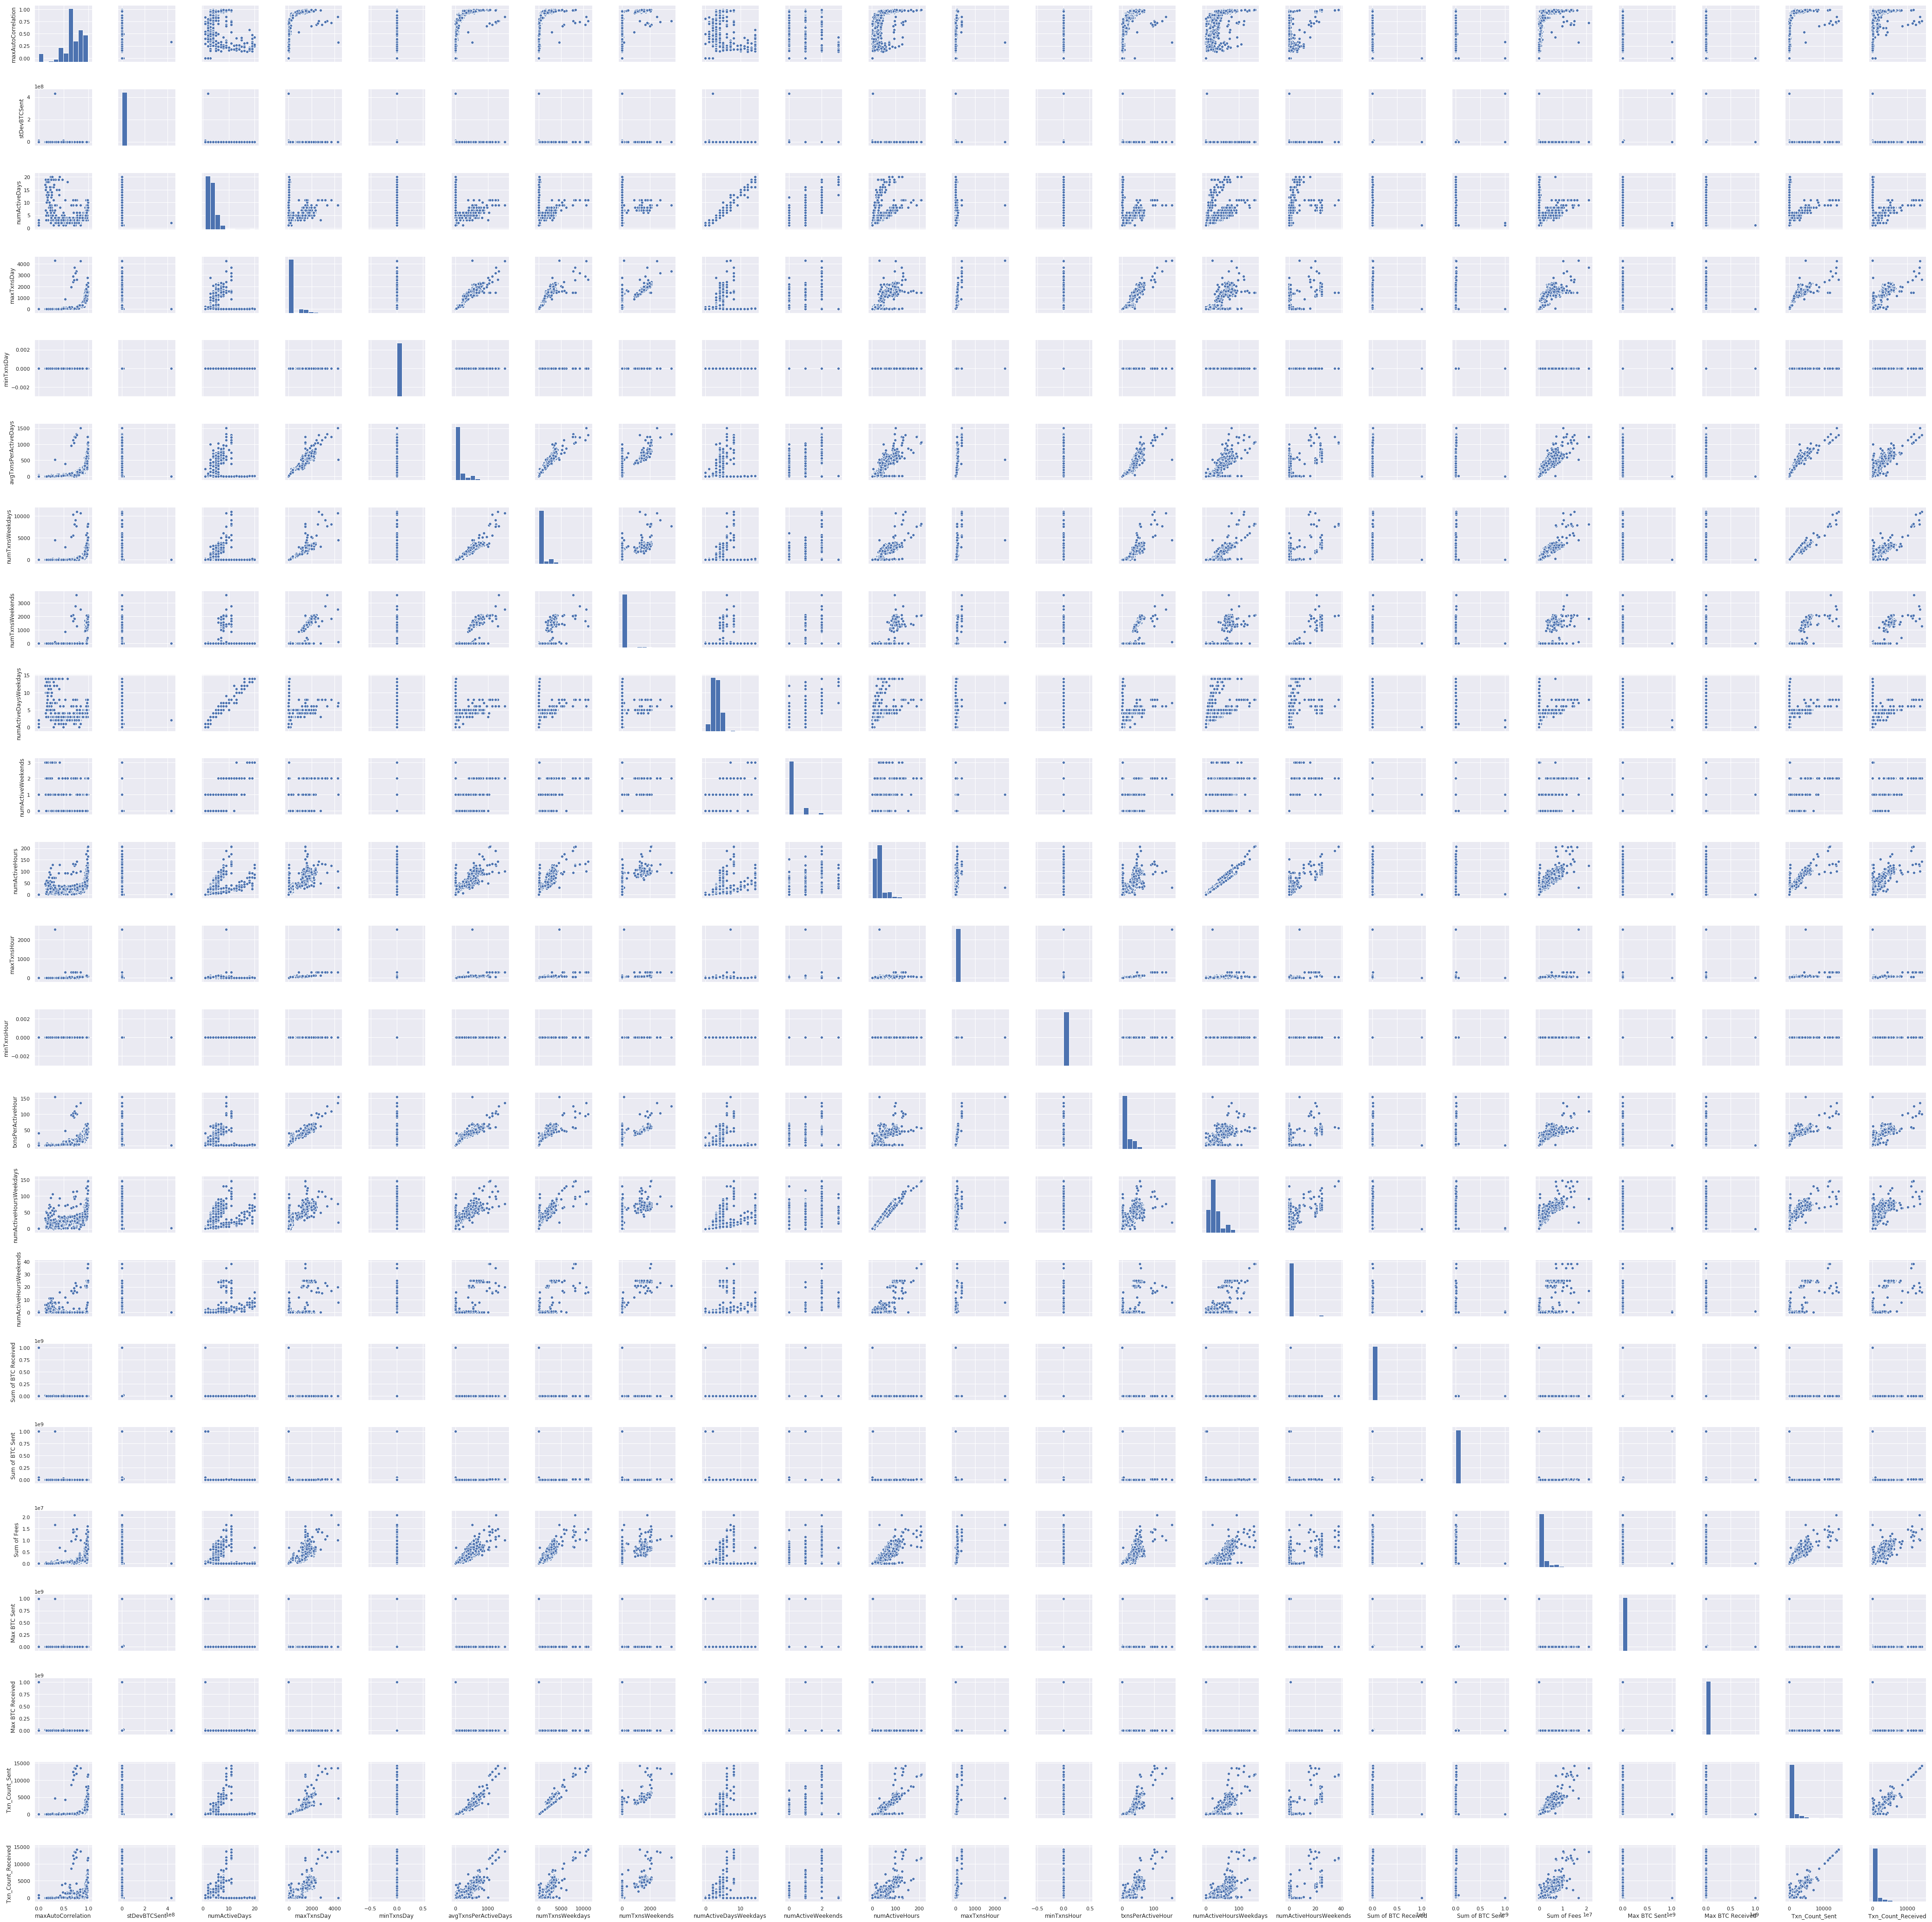

In [16]:
sns.pairplot(merged_df2)

In [17]:
merged_df2.columns

Index(['index', 'maxAutoCorrelation', 'stDevBTCSent', 'numActiveDays',
       'maxTxnsDay', 'minTxnsDay', 'avgTxnsPerActiveDays', 'numTxnsWeekdays',
       'numTxnsWeekends', 'numActiveDaysWeekdays', 'numActiveWeekends',
       'numActiveHours', 'maxTxnsHour', 'minTxnsHour', 'txnsPerActiveHour',
       'numActiveHoursWeekdays', 'numActiveHoursWeekends',
       'Sum of BTC Received', 'Sum of BTC Sent', 'Sum of Fees', 'Max BTC Sent',
       'Max BTC Received', 'Txn_Count_Sent', 'Txn_Count_Received'],
      dtype='object')

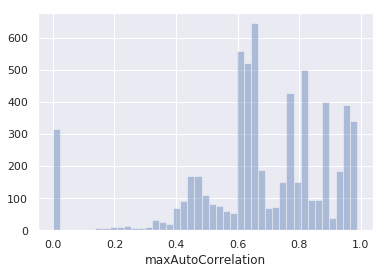

In [8]:
sns.distplot(merged_df2['maxAutoCorrelation'],kde=False)

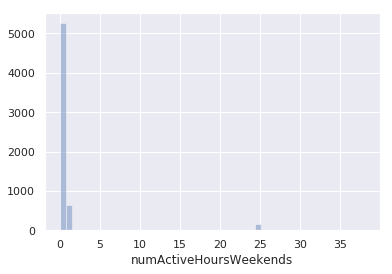

In [7]:
sns.distplot(merged_df2['numActiveHoursWeekends'],kde=False)

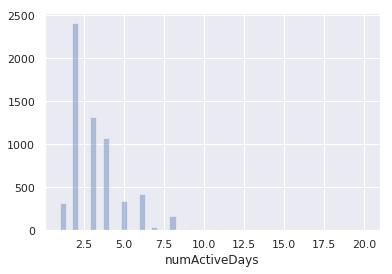

In [9]:
sns.distplot(merged_df2['numActiveDays'],kde=False)

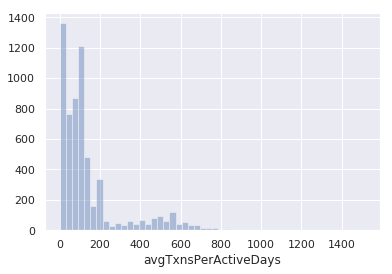

In [19]:
sns.distplot(merged_df2['avgTxnsPerActiveDays'],kde=False)

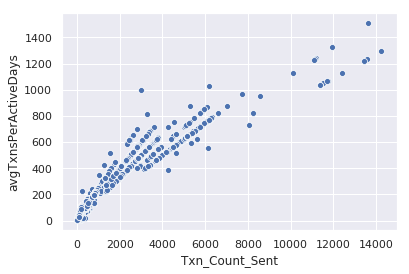

In [21]:
sns.scatterplot(y=merged_df2['avgTxnsPerActiveDays'],x=merged_df2['Txn_Count_Sent'])

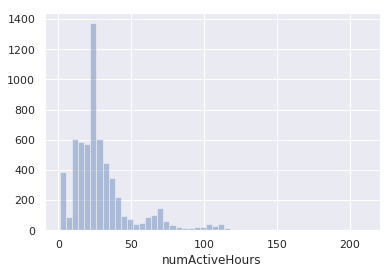

In [10]:
sns.distplot(merged_df2['numActiveHours'],kde=False)

In [38]:
merged_df2[merged_df2['maxAutoCorrelation']>0.98]

index  maxAutoCorrelation  numberofTxns  \
251   rBa3gX3UqF58ifZKtPXYYrgjRPkb4ArjZW            0.980727          5010   
458   rD6mZxz334LibzoLfm1LzAMbrFs7RtPSJw            0.983613          4668   
568   rKa9G1Pn7H9eu1fbZNbZvANBTMJ6v7vkep            0.981397         11388   
611   r3jBFfHe4dZUECLBcNEJzHAaLLxmWU2pj4            0.983456          6013   
634   rJ9LZK8wvDM4bH4xeFm1SbNdHg69NPAw6k            0.980909          4502   
855   rJvLFEeWttsnv6kfpN6euV4z9KyDhqzJCE            0.982673          5962   
932   rn9hU4bx16EmTyucxn6xqLXJhee1WxNcMi            0.988863          4609   
1651  rpFpcogsd8Ha3ZS33wAbsrbKETdxsiaoB3            0.980866          2490   
1844  rLAb7ohJkgQAUWa4tnTcRt9KG1rWBABa4o            0.982008          4633   
2006  rs6z3vDXtUPVYACHrious7QAx4znBcoaX2            0.980189          4654   
2182  rKWeJfhstn5AbRQfc65Goc6csDUadXTM3U            0.983351         11086   
2221  rGvFAsDiR8jpNsxv7JoydBbKYZMxYEdSno            0.986501         11736   
2295  r9ZoGHSMGN89ZjivC4R39g5RrvqwP2MpBT            0.980944          4507   
2628  rLxw6GNiyAcb8KnVQx3u91XhJd9ScikhMx            0.985815          7725   
2735  rBofXgf6s6mxEnZxG5Xvq6BAp5qwjLyYbH            0.981674         11391   
2800  rhMejNgsb2uT2wtyZQwAJXWDbe86bwrqgf            0.983284          5094   
2806  r4dqfEekfLubhTeShmcs6ToMbG6rjB8Bwy            0.987686          8244   
2908  rJMwgEs5HeEEHptFygr8nWN7qUbwFeugyN            0.983070          5118   
3149  rnkc55MDTEcyMrSh77RhX5UWNcUmVbkfGi            0.988358          5824   
3181  rGfSEUa5XHh6c16KbQBzuv163kJQZv5AtN            0.981208         11380   
3200  rERJPEHC943LVqbQXFYRuCFVmpegj3fVf3            0.982970          4475   
3255  rB9znU32PReyuJ1vsehfmnKp5R9X2Cy9Gk            0.986464          4379   
3363  r3kZyarTAFSJuGKb98UxMQGfWoNFbKpGAj            0.982262          5109   
3580  rpu9JJCgDWZX6KSW4QorC8vxUPetib4Wjw            0.986793         11187   
3666  rKLhCynztwz2FZN2DDPup1t4PknwLLdhLA            0.982166          5951   
3713  rUBUJ6xByMoVXTavYuBuKtGMY4wXqAfHex            0.983454          5857   
3725  rprBp2miK33gA9oyxqXeVyX6kbg9tgrTDC            0.982855          6013   
3732  rKWDsSZ6JZi7wy8JSGkx1ovp6pgrZBTZKt            0.983023          4539   
3737  r9qhm8ZpvKUN83bJgH3KzbyVMh7qKx8DVK            0.982282          4569   
3748  r3VC6jvrr3ny2fAPyGP3EjgKh9o4UrnpHE            0.987888         11128   
4079  rNTyvkL7Kv52qpw28W5W1Xp4rJwp9iSVRU            0.982837          5088   
4098  rPQKVvk3t1mgcSy49fxPogFba4PdweypLZ            0.983857          1598   
4129  r4sZWPCHLXRLc9odpd7sJgijPSiunAk2Gb            0.981063          4527   
4141  rQNdcSUBYeEW1xVnwHb1GS49np4A9XqHoK            0.986469          6085   
4412  rNZTq9ZAj5VQyNdnVJHULED9akjh4wi9yZ            0.981471          4615   
4432  rh5NJ7kZDaxcKwhrw6qTx2iKuu3eFs89ub            0.982635         11378   
4512  rPgnfb27k8ErWAG1dYfmVNNKTPv1HjSFck            0.981498          4173   
4535  rLhw4b5C1FYPcz6LSHF4b8PWBZwwyJ7Asd            0.981924         11073   
4575  rGS5FxbFc1URQ959ZKJDpWPYdJUEXY7GBk            0.981211          4697   
5014  rpVkYTTCpt5bT9ndsppAuWNCCVVU7yJhSL            0.986748         11696   
5045  r9Qo7hy41YJwapcUobqxj6B41rfmew3LQS            0.981514          5951   
5114  rEfD55VWdaFgdUtwjdXGDX8QxW8wyq5H8z            0.984074          5628   
5347  r9GsgP1ctjKK8pB8p7Rojn1MVh5pY2k1FK            0.981676          5753   
5875  rE2kP9vv11kjAyvesg7k4vnJDm8PwLTrtn            0.984536          5949   
5883  rKbPQ8YWhybS3R2kxhTBcGh1KvxNhnZi9q            0.984558          5150   
6074   rTnpTPxPhD77RD3wuetzL42DGGKqiH9xq            0.984001          4498   

      stDevBTCSent  numActiveDays  maxTxnsDay  minTxnsDay  \
251       0.030218              7      2038.0         0.0   
458       2.798188              8      1637.0         0.0   
568     292.215662             11      1440.0         0.0   
611       0.186326              8      2314.0         0.0   
634       0.160369              8      1631.0         0.0   
85

In [80]:
def plot_heatmap_bot_detection(data,user):
    #data is processed transaction dataframe
    plt.figure(figsize=(9, 3))
    
    plot_frame=timeseries_hourly_agg(data[data['Account']==user])
    plot_frame['Date'] = plot_frame.index.date
    plot_frame['Hour'] = plot_frame.index.hour
    
    df3 = pd.pivot_table(plot_frame, values='count_txns', index='Hour', columns='Date')
    sns.set()
    plt.subplot(121)
    sns.heatmap(df3,cmap='RdPu')
    plt.title('Txns Sent')
    
    
        
    plot_frame=timeseries_hourly_agg(data[data['Destination']==user])
    plot_frame['Date'] = plot_frame.index.date
    plot_frame['Hour'] = plot_frame.index.hour
    
    df3 = pd.pivot_table(plot_frame, values='count_txns', index='Hour', columns='Date')
    sns.set()
    plt.subplot(122)
    sns.heatmap(df3,cmap='RdPu')
    plt.title('Txns Received')
    plt.suptitle(user,y=1.05)
    plt.show()


In [23]:
xrp2.TimeStamp=pd.to_datetime(xrp2.TimeStamp)

In [26]:
type(xrp2['TimeStamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [42]:
import json

In [41]:
xrp2['AmountDEX'][0]

"{'value': 0.194958, 'currency': 'BTC', 'issuer': 'rDWid3Q68FT1o9dw8SzHfM76VXbdtiY4zF'}"

## Apply Labels to Bot Data

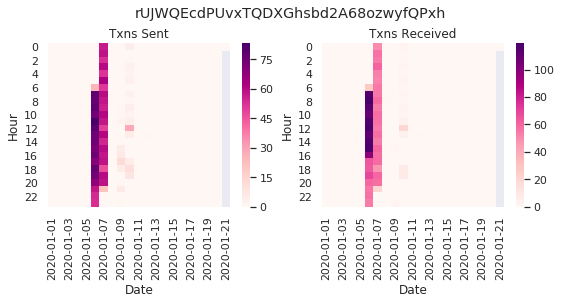

In [81]:
plot_heatmap_bot_detection(xrp2,'rUJWQEcdPUvxTQDXGhsbd2A68ozwyfQPxh')

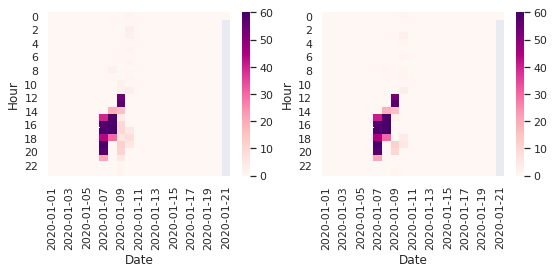

In [53]:
plot_heatmap_bot_detection(xrp2,'ranv1sdV5ezSrEGhPLXg3cD1BaUzxmyqWz')

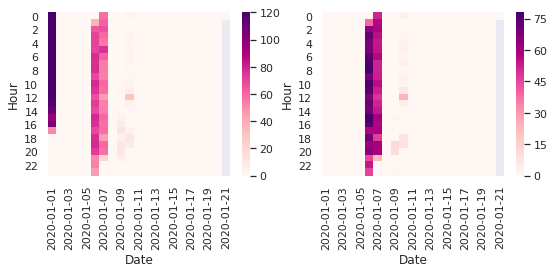

In [54]:
plot_heatmap_bot_detection(xrp2,'rBa3gX3UqF58ifZKtPXYYrgjRPkb4ArjZW')

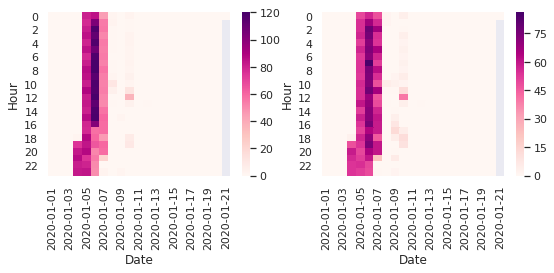

In [55]:
plot_heatmap_bot_detection(xrp2,'r3jBFfHe4dZUECLBcNEJzHAaLLxmWU2pj4')

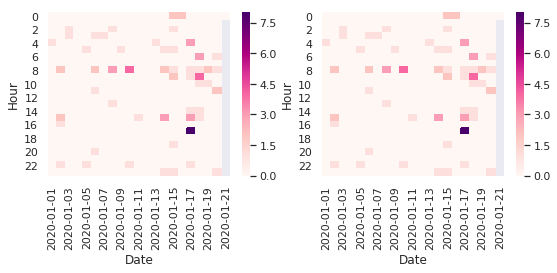

In [56]:
plot_heatmap_bot_detection(xrp2,'rf3B8KcYqKMgybB2ms9KcLhcB8bWX1UDov')

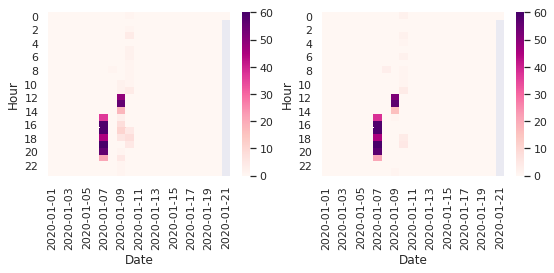

In [57]:
plot_heatmap_bot_detection(xrp2,'r9JcwCSpRtEd22aNKGwsEKEWBHWq44bnb7')

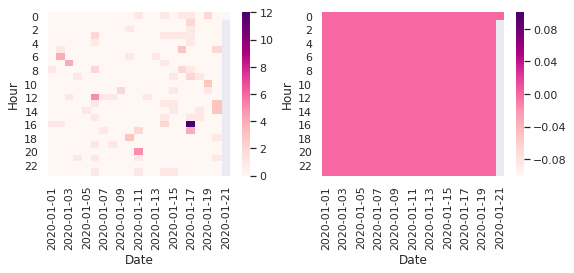

In [58]:
plot_heatmap_bot_detection(xrp2,'rpxZWvtjtty8hNH3YVbZhYVN4v1EYsmXRP')

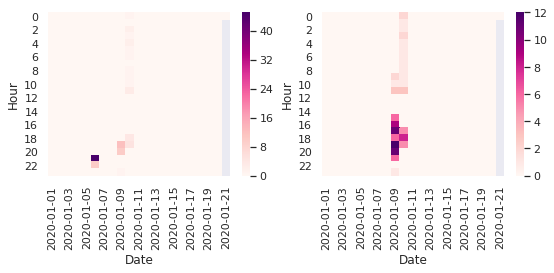

In [59]:
plot_heatmap_bot_detection(xrp2,'rJFnyzzFxvcY5ANenpMx9HU3VwnX6rXoVt')

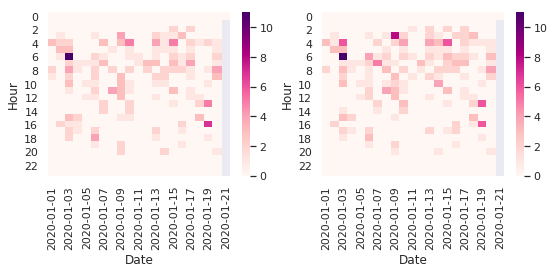

In [61]:
plot_heatmap_bot_detection(xrp2,'r99sqXsRXFSkyBVinWSDUwMo2HjVs6V5Cw')

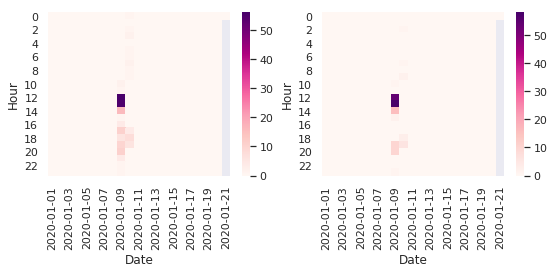

In [60]:
plot_heatmap_bot_detection(xrp2,'rDt9baxE7ehWf48e5mG6FpzMNaEGU2mC7r')

In [57]:
merged_df2[(merged_df2['numActiveDays']>10) & (merged_df2['maxAutoCorrelation']>0.9)]

index  maxAutoCorrelation  numberofTxns  \
568   rKa9G1Pn7H9eu1fbZNbZvANBTMJ6v7vkep            0.981397         11388   
2221  rGvFAsDiR8jpNsxv7JoydBbKYZMxYEdSno            0.986501         11736   
2735  rBofXgf6s6mxEnZxG5Xvq6BAp5qwjLyYbH            0.981674         11391   
3141  rUoVZfCo3rGTtSPqi3cbUHip7D5LCuW4bC            0.955843          8048   
3181  rGfSEUa5XHh6c16KbQBzuv163kJQZv5AtN            0.981208         11380   
4432  rh5NJ7kZDaxcKwhrw6qTx2iKuu3eFs89ub            0.982635         11378   
5014  rpVkYTTCpt5bT9ndsppAuWNCCVVU7yJhSL            0.986748         11696   
5863  rsP6Hfxqhv8Z5UVexBQBxZPg1T73ioKK67            0.975914          6143   

      stDevBTCSent  numActiveDays  maxTxnsDay  minTxnsDay  \
568     292.215662             11      1440.0         0.0   
2221     83.921301             11      1440.0         0.0   
2735    120.653308             11      1440.0         0.0   
3141      0.010154             11      1638.0         0.0   
3181    115.361916             11      1440.0         0.0   
4432    144.975035             11      1440.0         0.0   
5014    158.454184             11      1440.0         0.0   
5863      0.000161             11      1544.0         0.0   

      avgTxnsPerActiveDays  numTxnsWeekdays  numTxnsWeekends  ...  \
568            1035.272727           7866.0           2082.0  ...   
2221           1066.909091           8196.0           2100.0  ...   
2735           1035.545455           7870.0           2081.0  ...   
3141            731.636364           5659.0           1368.0  ...   
3181           1034.545455           7858.0           2082.0  ...   
4432           1034.363636           7868.0           2070.0  ...   
5014           1063.272727           8175.0           2081.0  ...   
5863            558.454545           4479.0           1409.0  ...   

      txnsPerActiveHour  numActiveHoursWeekdays  numActiveHoursWeekends  \
568           55.281553                     144                      38   
2221          55.885714                     148                      38   
2735          55.565854                     143                      38   
3141          46.252874                     125                      25   
3181          55.242718                     144                      38   
4432          55.233010                     144                      38   
5014          56.230769                     146                      38   
5863          44.839416                     107                      25   

      Sum of BTC Received  Sum of BTC Sent  Sum of Fees  Max BTC Sent  \
568          5.928548e+06     5.929215e+06     16114016   1487.979199   
2221         5.379320e+06     5.380333e+06      9861743   1200.047683   
2735         4.858545e+06     4.862159e+06     12212297   2000.000000   
3141         9.042495e+02     6.215258e+02     12950307      0.310791   
3181         4.952396e+06     4.954267e+06     13664997   1440.589896   
4432         4.889455e+06     4.889217e+06      7047286   1948.333333   
5014         4.533135e+06     4.534280e+06     13607927   1200.006219   
5863         7.782879e+01     1.222667e+01      8423529      0.002153   

      Max BTC Received  Txn_Count_Sent  Txn_Count_Received  
568        1487.989481         11388.0             11427.0  
2221       1000.006910         11736.0             11781.0  
2735       2000.013820         11391.0             11433.0  
3141        461.327026          8048.0              5547.0  
3181       1203.674984         11380.0             11435.0  
4432       1948.346796         11378.0             11417.0  
5014       1200.008292         11696.0             11743.0  
5863         50.000000          6143.0              4476.0  

[8 rows x 25 columns]

## Random Sample 100 accounts to classify

#### It appears there are roughly 3 archetypes of users that will be classfied:

1. Those that are highly active (lots of txns) for one day or for multiple days
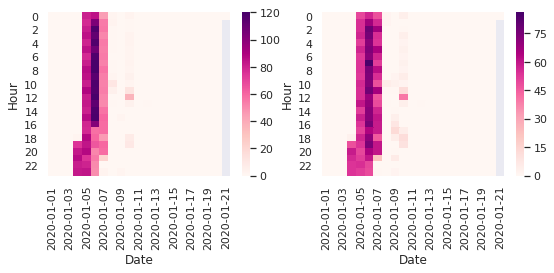


2. Those that show bursts of activity but are only active for a few hours of the day
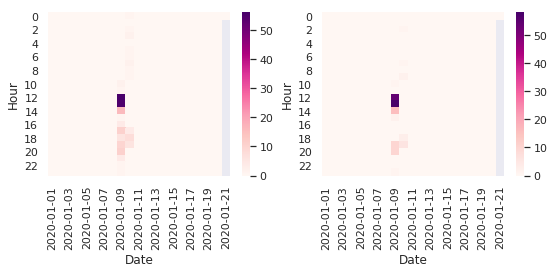



3. Those that are active all the time but not high in txns sent
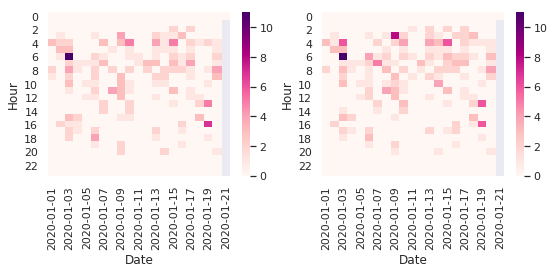

In [88]:
listToClassify=merged_df2.sample(n=100, random_state=42, axis=0)['index']

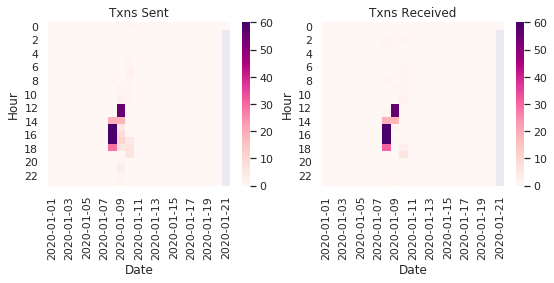

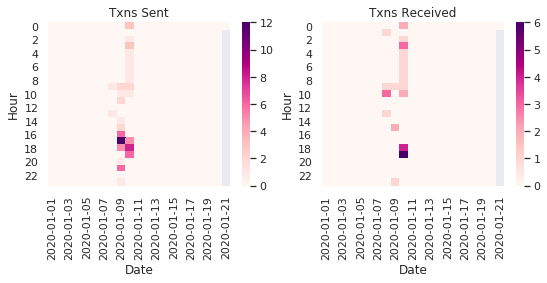

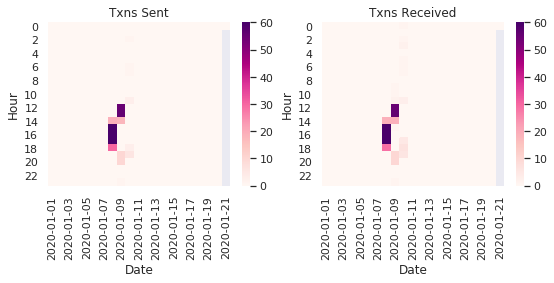

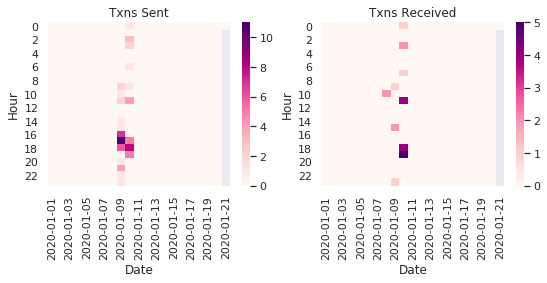

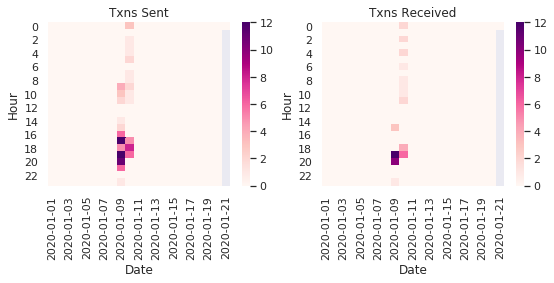

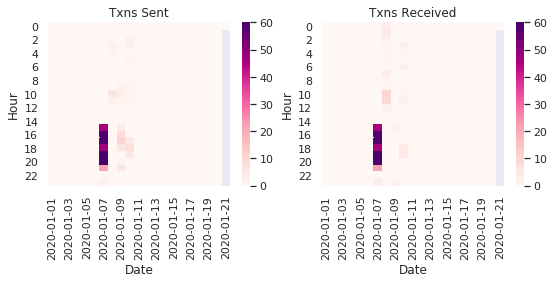

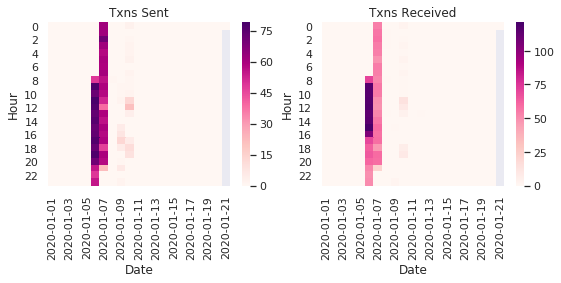

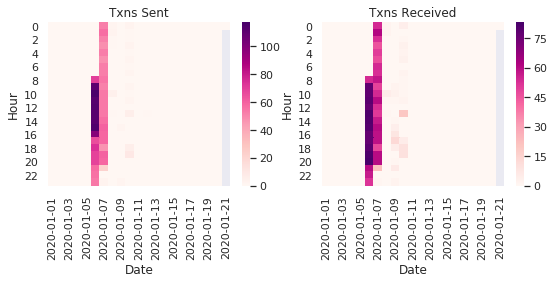

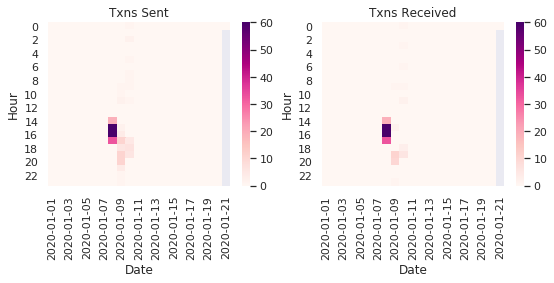

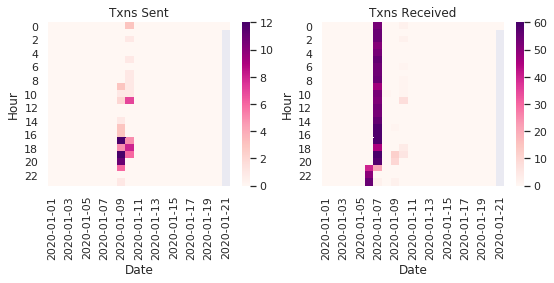

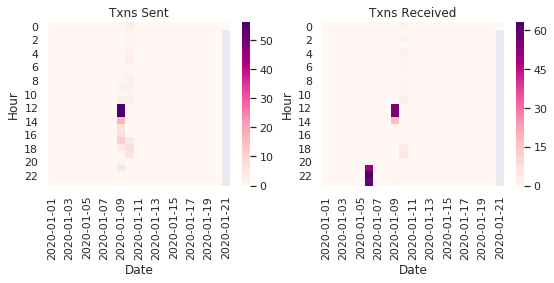

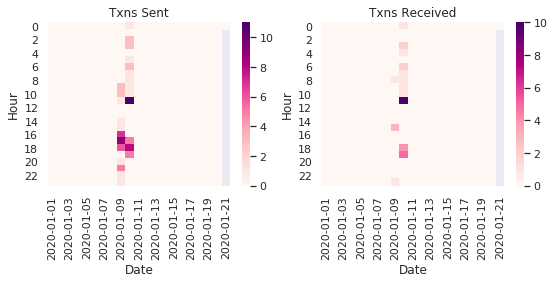

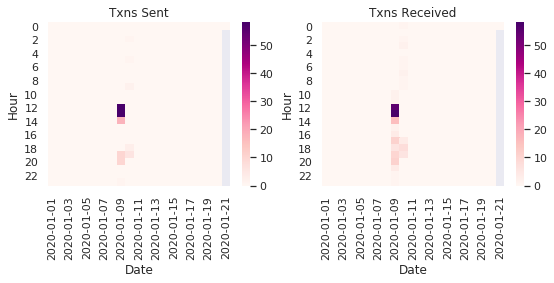

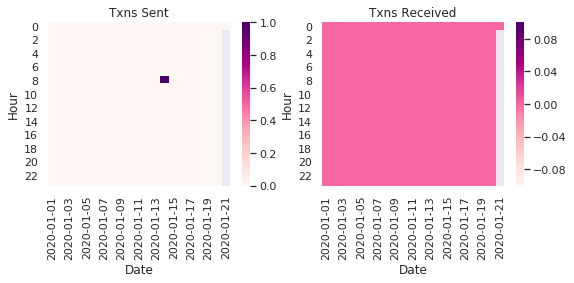

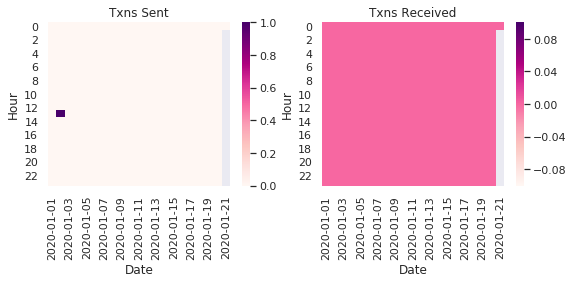

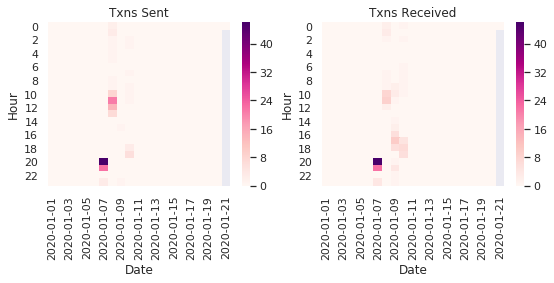

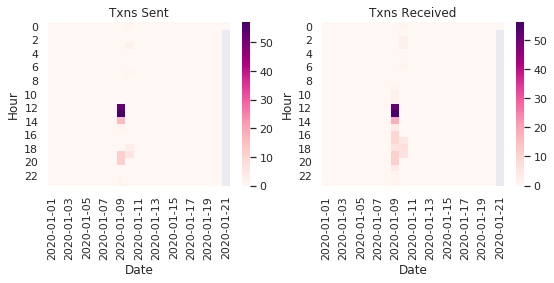

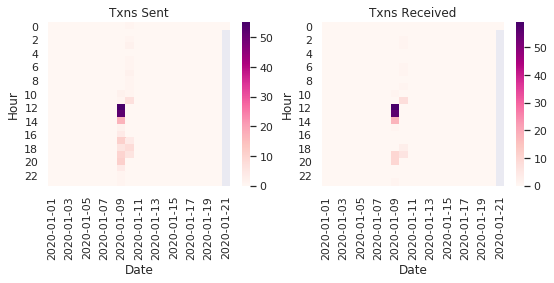

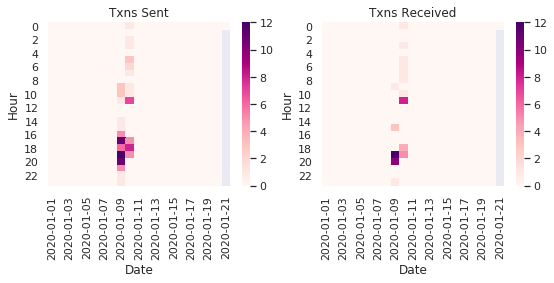

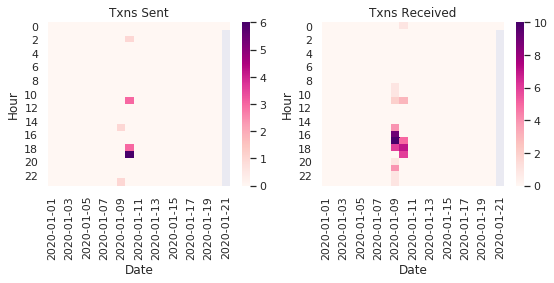

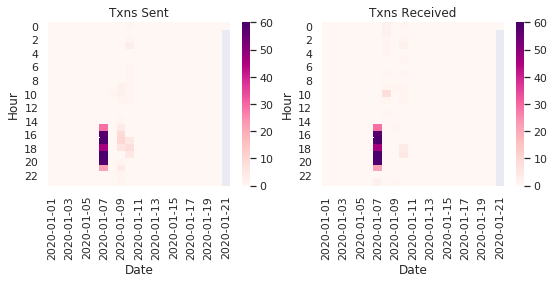

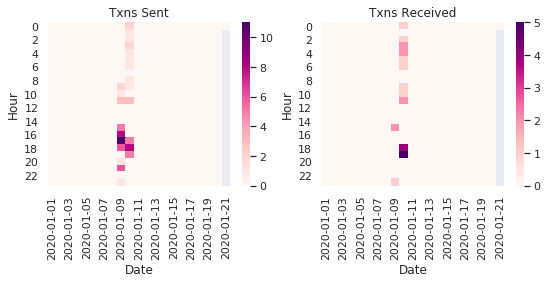

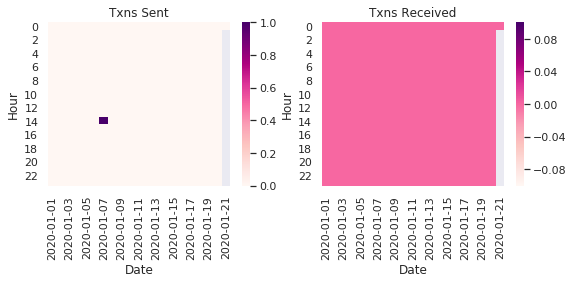

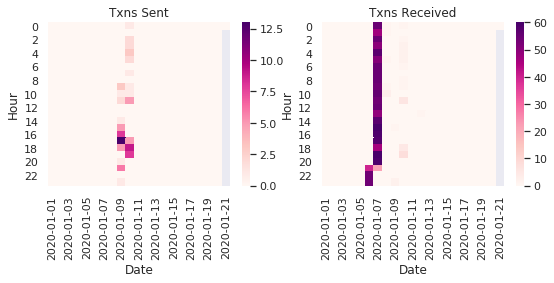

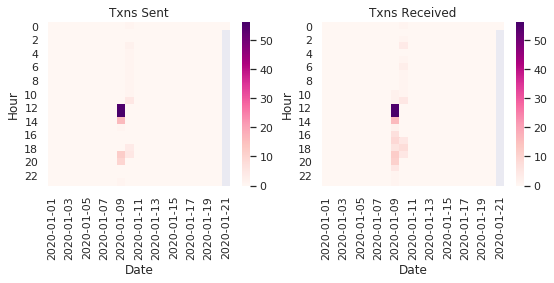

In [75]:
for x in listToClassify[:25]:
    plot_heatmap_bot_detection(xrp2,x)

In [107]:
label_2=[0,1,2,3,4,5,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
label_1=[6,7]
label_3=[]

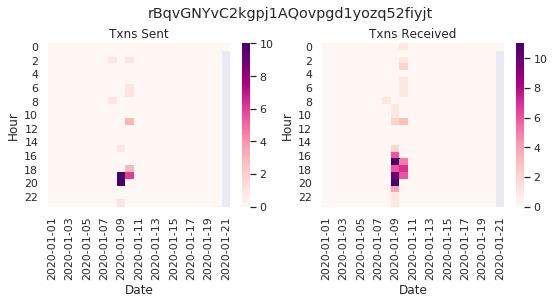

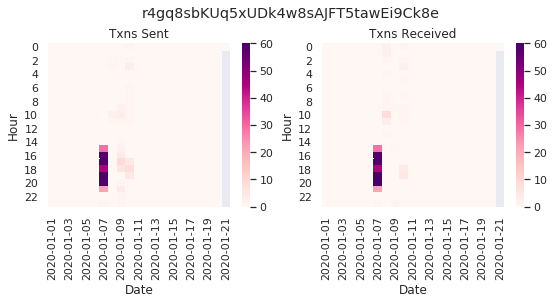

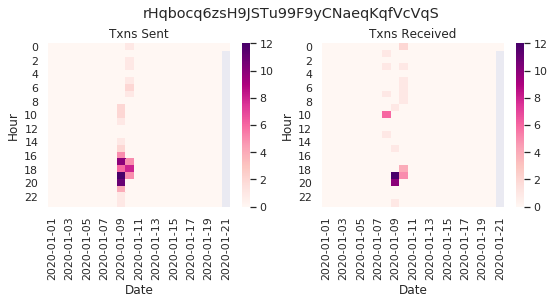

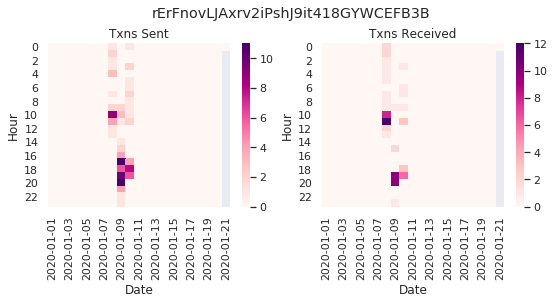

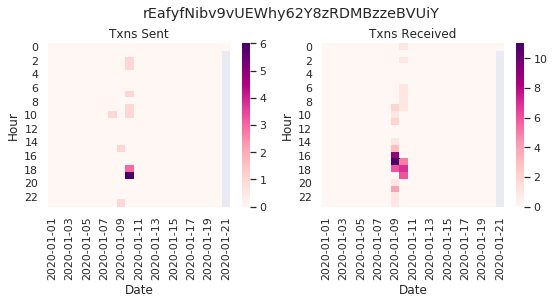

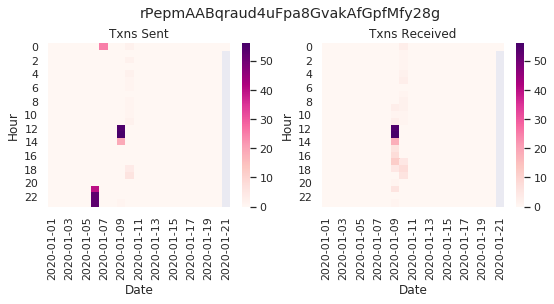

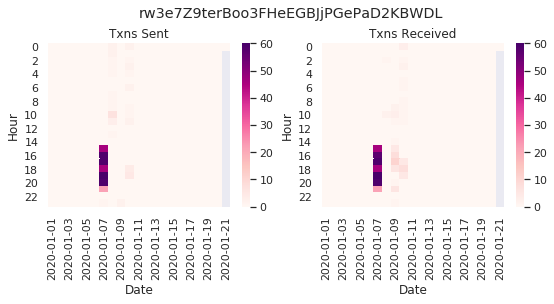

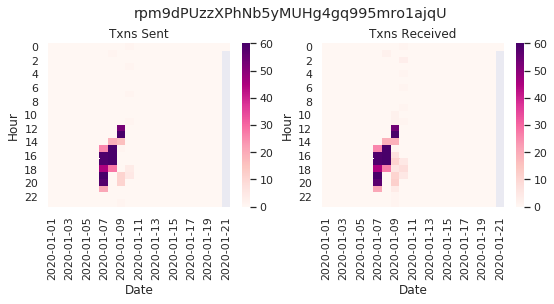

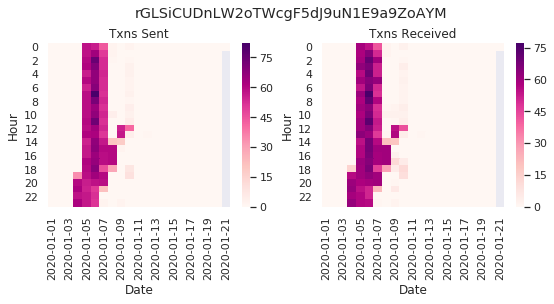

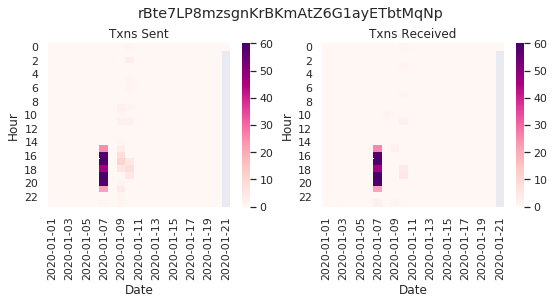

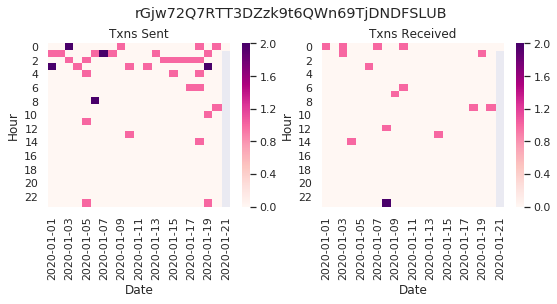

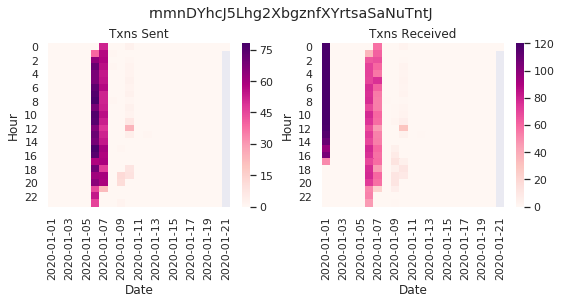

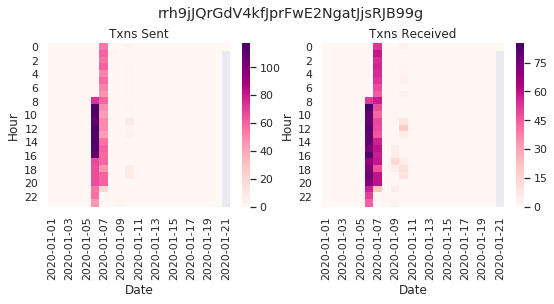

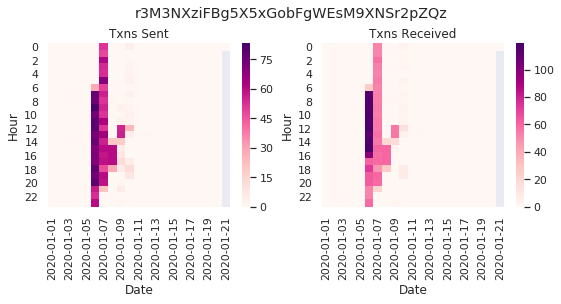

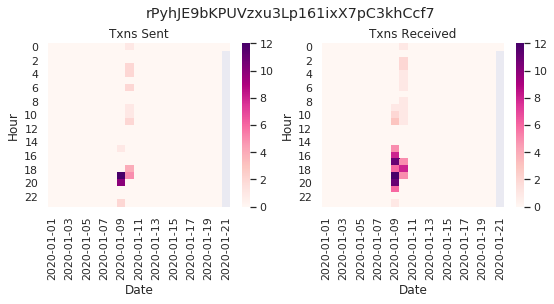

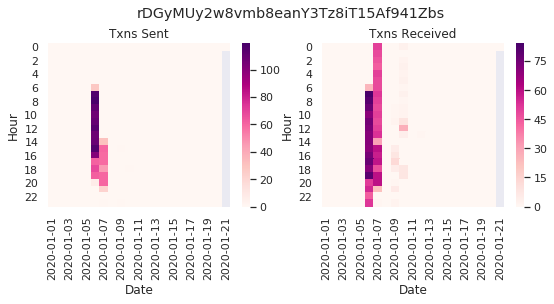

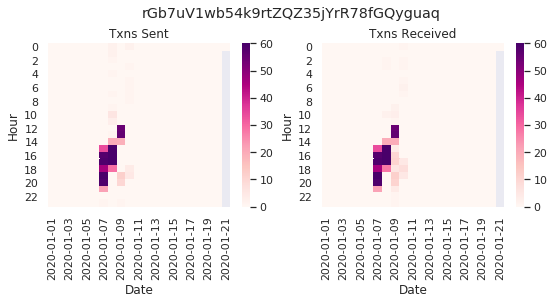

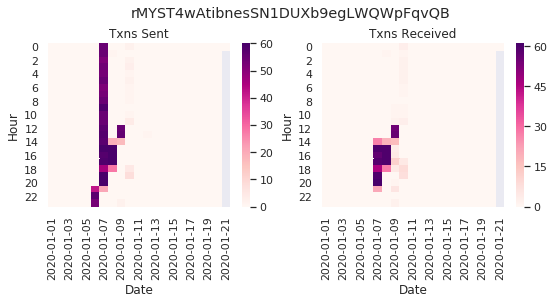

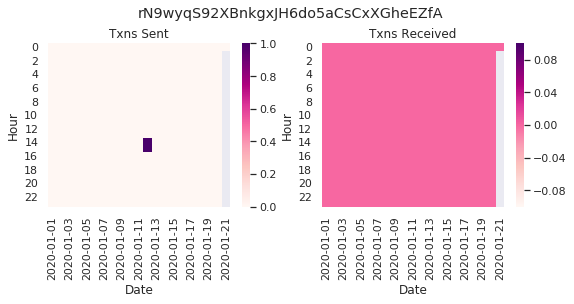

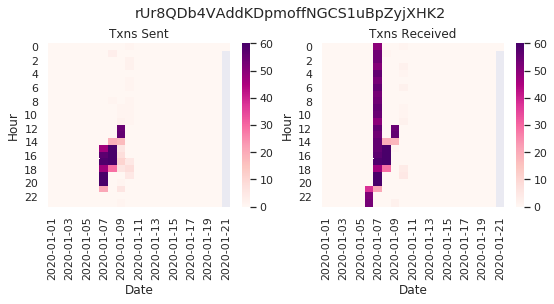

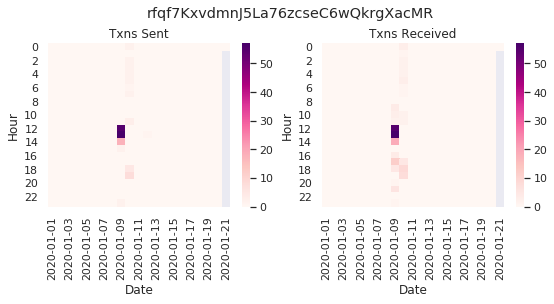

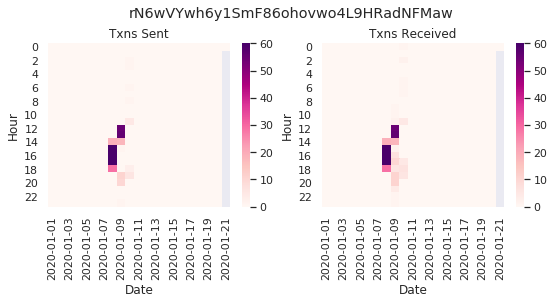

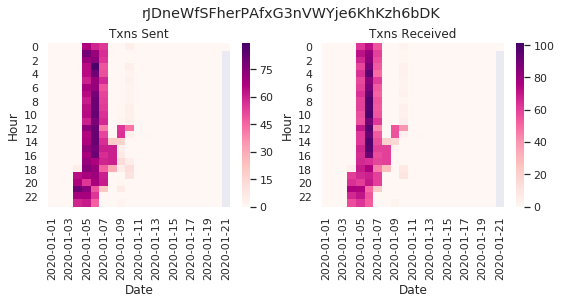

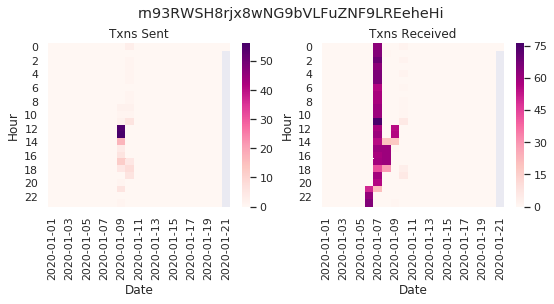

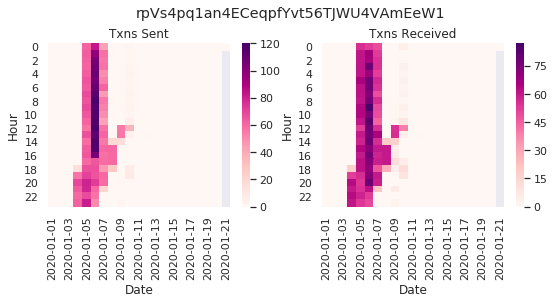

In [86]:
for x in listToClassify[25:50]:
    plot_heatmap_bot_detection(xrp2,x)

In [103]:
np.arange(25,31,1).tolist()

[25, 26, 27, 28, 29, 30]

In [109]:
label_2.extend([25,26,27,28,29,30,31,34,39,41,43,44,45,46,48])

In [111]:
label_1.extend([33,36,37,38,40,42,47,49])

In [112]:
label_3.extend([35])

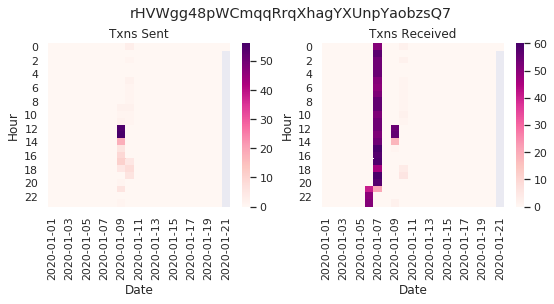

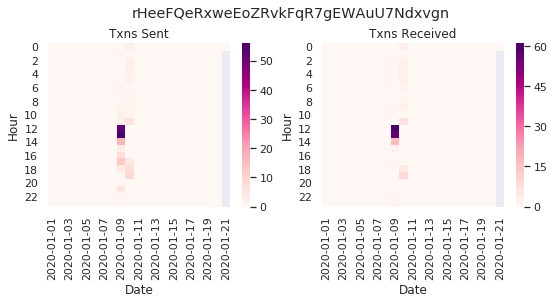

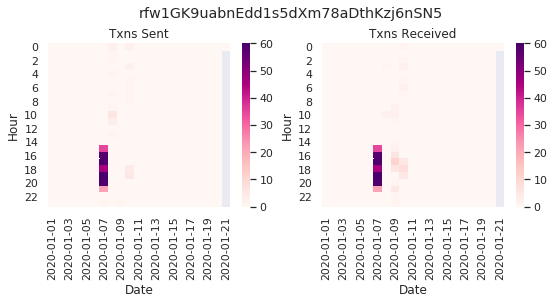

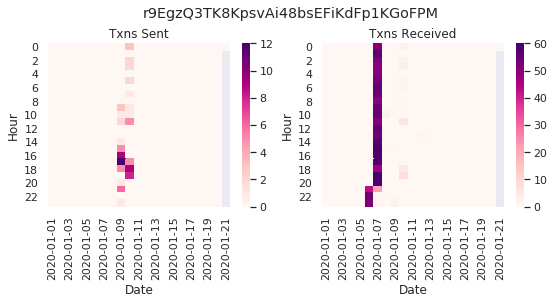

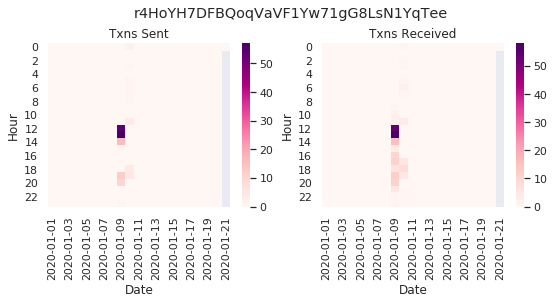

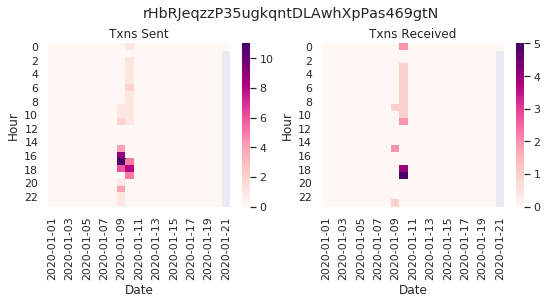

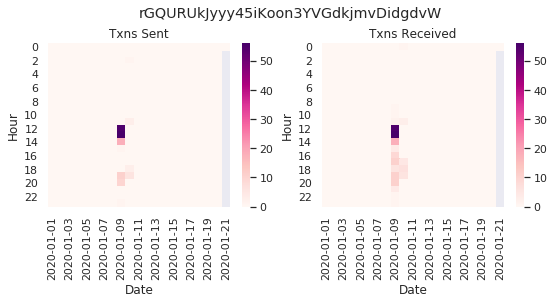

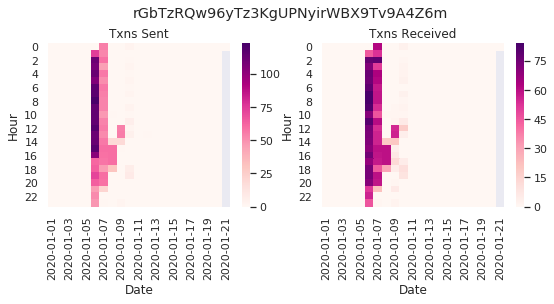

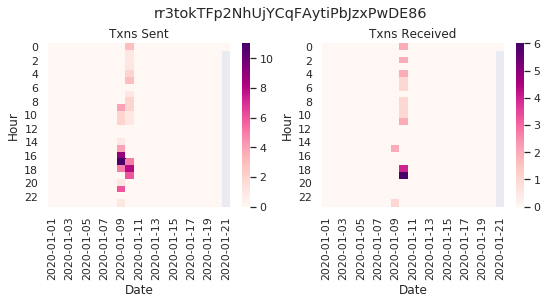

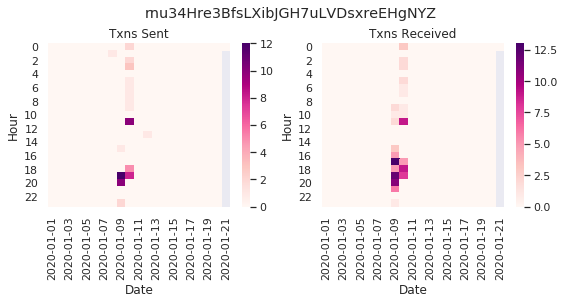

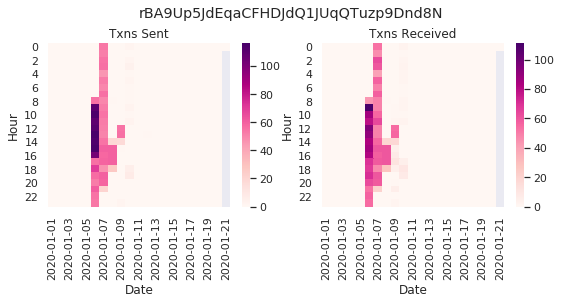

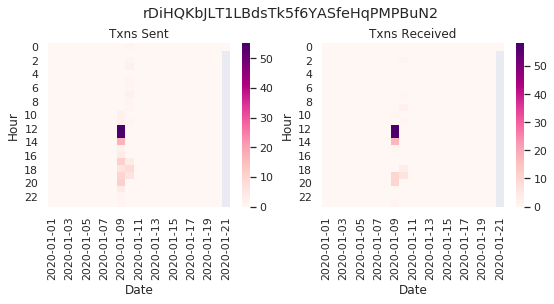

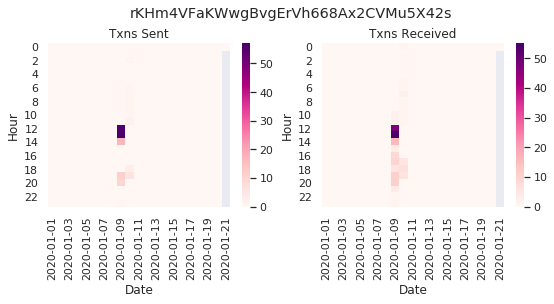

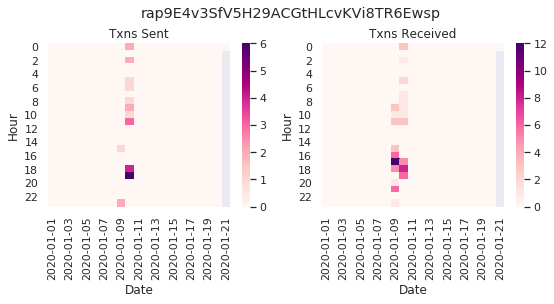

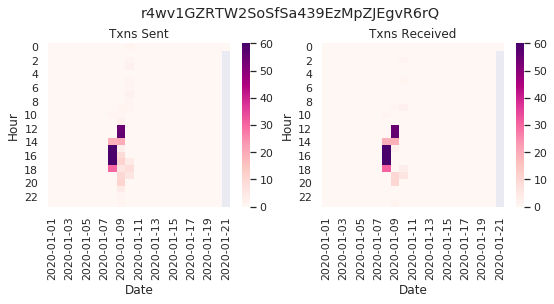

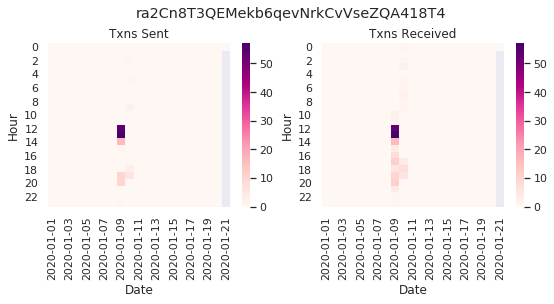

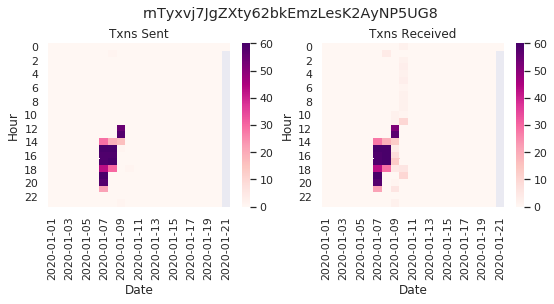

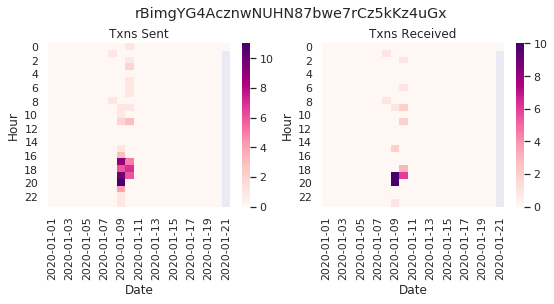

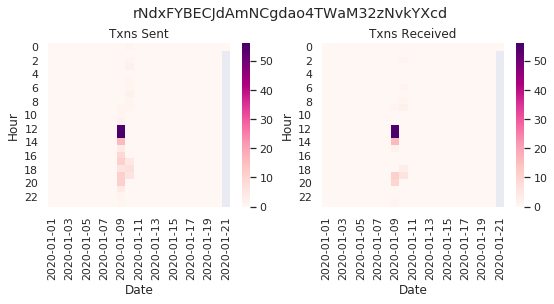

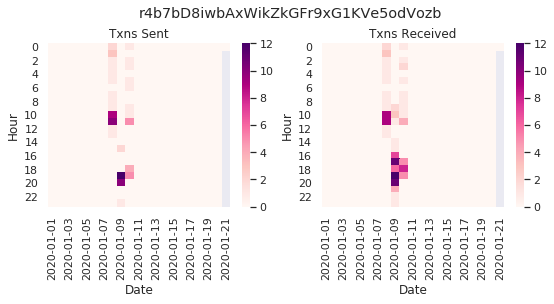

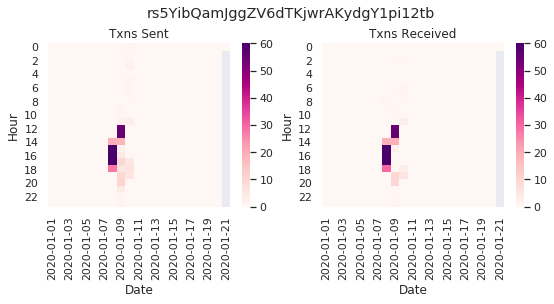

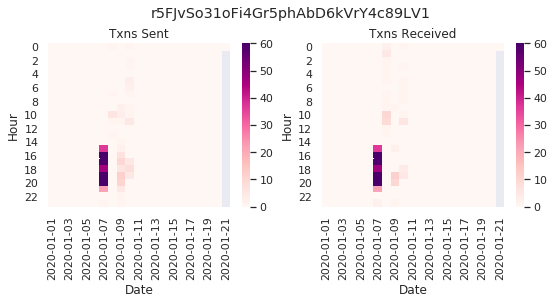

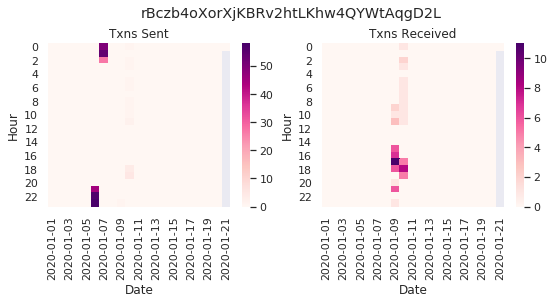

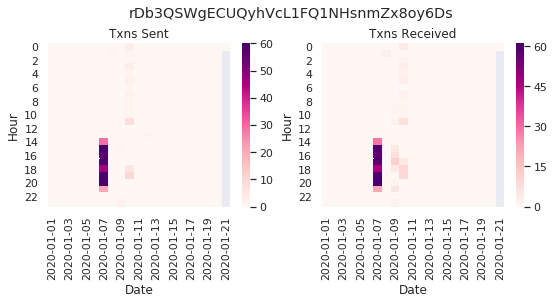

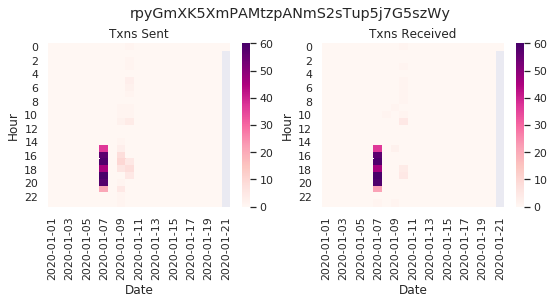

In [90]:
for x in listToClassify[50:75]:
    plot_heatmap_bot_detection(xrp2,x)

In [197]:
labels_1=[listToClassify.iloc[x] for x in label_1]

In [198]:
labels_2=[listToClassify.iloc[x] for x in label_2]

In [199]:
labels_3=[listToClassify.iloc[x] for x in label_3]

In [200]:
len(labels_1)

10

In [201]:
len(labels_2)

30

In [202]:
len(labels_3)

1

In [192]:
merged_df2['label'] = merged_df2.apply(lambda row: 1 if row['index'] in labels_1 else
                                       (2 if row['index'] in labels_2 else
                                       (3 if row['index'] in labels_3 else None)), axis = 1) 

Need to label more label_3 and label_1 accounts

In [203]:
labels_3.extend(merged_df2.loc[(merged_df2['maxAutoCorrelation']<0.3) & (merged_df2['numberofTxns']>20)]['index'].tolist())

In [204]:
labels_1.extend(merged_df2.loc[(merged_df2['maxAutoCorrelation']>0.9) & (merged_df2['numberofTxns']>500)][:30]['index'].tolist())

In [205]:
len(labels_1)

40

In [206]:
len(labels_2)

30

In [207]:
len(labels_3)

43

In [208]:
merged_df2['label'] = merged_df2.apply(lambda row: 1 if row['index'] in labels_1 else
                                       (2 if row['index'] in labels_2 else
                                       (3 if row['index'] in labels_3 else None)), axis = 1) 

In [218]:
merged_df2=merged_df2.drop('numberofTxns',axis=1)

KeyError: "['numberofTxns'] not found in axis"

In [219]:
labeled_data=merged_df2[merged_df2['label'].notnull()]

In [220]:
labeled_data.shape

(112, 25)

In [235]:
x_labeled=labeled_data.iloc[:,1:24]

In [236]:
y_labeled=labeled_data.iloc[:,24:]

In [242]:
from sklearn.preprocessing import RobustScaler

In [243]:
rs=RobustScaler()

In [244]:
x_labeled_scaled=rs.fit_transform(x_labeled)

In [215]:
from sklearn import semi_supervised

In [233]:
ls=semi_supervised.LabelSpreading(kernel='knn')

In [245]:
ls.fit(x_labeled_scaled,y_labeled)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelSpreading(alpha=0.2, gamma=20, kernel='knn', max_iter=30, n_jobs=None,
               n_neighbors=7, tol=0.001)

In [255]:
x=merged_df2.iloc[:,1:24]

In [256]:
x_scaled=rs.fit_transform(x)

In [257]:
pred_y=ls.predict(x_scaled)

In [258]:
merged_df2['pred_y']=pred_y

In [259]:
merged_df2

index  maxAutoCorrelation  stDevBTCSent  \
0     rhPzNuzmDKSdf3B19zUq1gawgWU9Rx4rVg            0.000000      0.000000   
1     rUJWQEcdPUvxTQDXGhsbd2A68ozwyfQPxh            0.971461      0.072580   
2     rDt9baxE7ehWf48e5mG6FpzMNaEGU2mC7r            0.635093      0.006444   
3     rhQbfRFjrDkD84SPFxQLWBMTX7zeNXuooR            0.673997      0.044883   
4      raijXae8iaZUtpkKeHed3u5E1k74A5S2X            0.000000      0.000000   
...                                  ...                 ...           ...   
6161  rL6QWTXDyp5YQWj3S3tm9ezodjycSWJHUd            0.496956      0.016299   
6162  rEBegW6dZUUf2W9nd4ABXVfxMktvSAaTJs            0.613334      0.004731   
6163  r9JcwCSpRtEd22aNKGwsEKEWBHWq44bnb7            0.824679      0.010942   
6164  ranv1sdV5ezSrEGhPLXg3cD1BaUzxmyqWz            0.819672      0.021804   
6165  rEqf4ynCWoeEN2YZfHDR3Kr5ZaVK92MrUL            0.821743      0.003982   

      numActiveDays  maxTxnsDay  minTxnsDay  avgTxnsPerActiveDays  \
0                 1         1.0         0.0              1.000000   
1                 6      1245.0         0.0            431.500000   
2                 2       179.0         0.0            103.500000   
3                 2       188.0         0.0            108.000000   
4                 1         1.0         0.0              1.000000   
...             ...         ...         ...                   ...   
6161              3        32.0         0.0             25.666667   
6162              2       155.0         0.0             88.000000   
6163              4       337.0         0.0            134.250000   
6164              4       340.0         0.0            198.000000   
6165              4       338.0         0.0            196.000000   

      numTxnsWeekdays  numTxnsWeekends  numActiveDaysWeekdays  ...  \
0                 1.0              0.0                      1  ...   
1              2588.0              1.0                      5  ...   
2               207.0              0.0                      2  ...   
3               216.0              0.0                      2  ...   
4                 0.0              1.0                      0  ...   
...               ...              ...                    ...  ...   
6161             77.0              0.0                      3  ...   
6162            176.0              0.0                      2  ...   
6163            537.0              0.0                      4  ...   
6164            792.0              0.0                      4  ...   
6165            784.0              0.0                      4  ...   

      numActiveHoursWeekends  Sum of BTC Received  Sum of BTC Sent  \
0                          0             0.000000        31.000000   
1                          1          1203.816850      1099.484278   
2                          0           102.842429         2.859425   
3                          0           119.618779        19.733373   
4                          1             0.000000        16.000000   
...                      ...                  ...              ...   
6161                       0             2.212176         2.185999   
6162                       0             3.067861         3.050917   
6163                       0           119.784315        19.825364   
6164                       0           170.234806        70.331764   
6165                       0           113.618223        13.637095   

      Sum of Fees  Max BTC Sent  Max BTC Received  Txn_Count_Sent  \
0              15     31.000000           0.00000             1.0   
1         7888478      0.461339          50.00000          2589.0   
2          774314      0.016997          50.00000           207.0   
3          978893      0.114594          50.00000           216.0   
4              15     16.000000           0.00000             1.0   
...           ...           ...               ...             ...   
6161       283571      0.156121           0.02636            77.0   
6162       546671      0.067359    

In [261]:
merged_df2.to_csv('Data/labeleddata.csv')

In [262]:
merged_df2['pred_y'].value_counts()

2.0    3380
1.0    2078
3.0     708
Name: pred_y, dtype: int64